# 19-Brain_overview

A comparison view of the white and gray matter data.

In [33]:
# load packages
suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(goseq))
suppressPackageStartupMessages(library(org.Mmu.eg.db))
suppressPackageStartupMessages(library(ggrepel))

suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(reshape2))
library(patchwork)
library(umap)
library(Rtsne)

temp<-read.csv(file = "../../05-sample_overview/full_tissue_color.csv",header = F)
color_ft<-temp$V2
names(color_ft)<-temp$V1
color_ft



Spleen              Kidney       Adrenal Gland      Brain:Brain-Gr 
          "#BC80BD"           "#BEBADA"           "#8DD3C7"           "#FB8072" 
     Brain:Brain-Wh               Liver                Lung  Lymph node:LN-AX-R 
          "#a34136"           "#fff265"           "#80B1D3"           "#FDB462" 
Lymph node:LN-ING-L   Lymph node:LN-MES       Lymph node:NA                PBMC 
          "#ed830c"           "#f5b771"           "#ff8700"           "#B3DE69" 
    Sex Organ:Ovary Sex Organ:Sex-Organ    Sex Organ:Testis       Skin:Non-Rash 
          "#e64e9b"           "#FCCDE5"           "#a82d6c"           "#6e6969" 
          Skin:Rash          SpinalCord         Whole blood 
          "#D9D9D9"           "#f93d28"           "#CCEBC5"

In [3]:
# load project helper functions
source('../../prj_helpers.R')

In [5]:
# load pre-qc'ed data
se.qc <-readRDS(file="..//../06-tissue-specific-markers/dds.qc.experimental.alltp")


In [6]:
# Get the names of the tissue labels
unique(se.qc$tissue)

[1] Spleen        Kidney        Liver         Brain         Sex Organ    
 [6] Lymph node    Skin          Adrenal Gland Lung          Whole blood  
[11] PBMC         
14 Levels: Adrenal Gland Brain Kidney Liver Lung Lymph node Ovary ... Whole blood

In [281]:
PlotsTissue<-function(Tissue,baseline){
    # Subset to samples of interest
tissue_of_interest <- Tissue
#baseline<-0
se.qc.tissue <- se.qc[,
    se.qc$tissue == tissue_of_interest & se.qc$SampleType == 'Experimental']

# remove viral genes
se.qc.tissue <- se.qc.tissue[!rowData(se.qc.tissue)$viralGene,]
se.qc.tissue$infected <- factor(ifelse(se.qc.tissue$dpi_time_2 > baseline,"infected","noninfected"))
se.qc.tissue$infected <- relevel(se.qc.tissue$infected, ref="noninfected")
dds_simple <- DESeqDataSet(se.qc.tissue, ~infected)
dds_simple <- DESeq(dds_simple)

rld <- vst(dds_simple)
vsd.qc <- vst(dds_simple)
ntop = 4000
rv <- rowVars(assay(vsd.qc))
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop,length(rv)))]
set.seed(20191)
d2 <- data.frame(colData(dds_simple))


pca <- prcomp(t(assay(vsd.qc)[select,]))
percentVar <- pca$sdev ^ 2 / sum(pca$sdev ^ 2)
d2 <-data.frame( PC1 = pca$x[, 1],
        PC2 = pca$x[, 2],
        PC3 = pca$x[, 3],
        PC4 = pca$x[, 4],
        PC5 = pca$x[, 5],
        PC6 = pca$x[, 6],
        PC7 = pca$x[, 7],
        PC8 = pca$x[, 8],
        PC9 = pca$x[, 9],
        PC10 = pca$x[, 10],
        d2,
        name = colnames(vsd.qc)
      )

gene_map <- as.data.frame(rowData(se.qc.tissue)[,c('Geneid','external_gene_name')])
PCA1<-ggplot(d2 %>% arrange(desc(SampleType))) + 
    geom_point(size=5, 
               aes(x=PC1,y=PC2,col=full.tissue,alpha=SampleType,label=biosample))+scale_alpha_manual(values=c(1,0.8),guide="none")+
  scale_color_manual(name="Tissue",values =color_ft[as.character(unique(d2$full.tissue))] )+
    ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +theme_bw()+
    theme(text=element_text(size=12,color='black'),panel.border = element_rect(colour = "black", fill=NA, size=1))


PCA2<-ggplot(d2 %>% arrange(desc(SampleType))) + 
    geom_point(size=5, 
               aes(x=PC1,y=PC2,col=as.numeric(dpi_time_2),alpha=SampleType,label=biosample))+scale_alpha_manual(values=c(1,0.8),guide="none")+
  scale_colour_gradientn(colours = brewer.pal(n = 100, name = "Blues"),name="DPI")+
    ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +theme_bw()+
theme(text=element_text(size=12,color='black'),panel.border = element_rect(colour = "black", fill=NA, size=1))
options(repr.plot.width = 10, repr.plot.height = 4)

Diff <- lapply(unique(se.qc.tissue$full.tissue), function(curr_tissue) {
    print(paste("This is the current tissue:",curr_tissue))
    se.qc.tissue<-se.qc.tissue[,se.qc.tissue$full.tissue %in% c(curr_tissue)]
    sort(unique(se.qc.tissue$dpi_time_factor))
    dds_time <- DESeqDataSet(se.qc.tissue, ~dpi_time_factor)
    dds_time <- DESeq(dds_time)
     
    res.pp <- list()

    if(!baseline %in% unique(dds_time$dpi_time_2)){
        baseline = 3
    }
    if(8 %in% unique(dds_time$dpi_time_2) ){
     res8 <- results(dds_time,contrast = c('dpi_time_factor','8',baseline))
     res.pp<-append(res.pp,list(tp8 = post_process_res(res8,se = se.qc.tissue)))
    }
    if(7 %in% unique(dds_time$dpi_time_2) ){
     res7 <- results(dds_time,contrast = c('dpi_time_factor','7',baseline))
     res.pp<-append(res.pp,list(tp7 = post_process_res(res8,se = se.qc.tissue)))
    }
    if(6 %in% unique(dds_time$dpi_time_2) ){
     res6 <- results(dds_time,contrast = c('dpi_time_factor','6',baseline))
     res.pp<-append(res.pp,list(tp6 = post_process_res(res6,se = se.qc.tissue)))
    }
       
    if(5 %in% unique(dds_time$dpi_time_2) ){
     res5 <- results(dds_time,contrast = c('dpi_time_factor','5',baseline))
     res.pp<-append(res.pp,list(tp5 = post_process_res(res5,se = se.qc.tissue)))
    }
     if(4 %in% unique(dds_time$dpi_time_2) ){
     res4 <- results(dds_time,contrast = c('dpi_time_factor','4',baseline))
     res.pp<-append(res.pp,list(tp4 = post_process_res(res3,se = se.qc.tissue)))
    }
    if(3 %in% unique(dds_time$dpi_time_2) && baseline ==0 ){
     res3 <- results(dds_time,contrast = c('dpi_time_factor','3',baseline))
     res.pp<-append(res.pp,list(tp3 = post_process_res(res3,se = se.qc.tissue)))
    }
   
    DE<-bind_rows(res.pp, .id = "DPI")
    
    output<-DE
    print(DE)
    })

names(Diff)<-unique(se.qc.tissue$full.tissue)
de.genes.Infection<-bind_rows(Diff, .id = "tissue")

n.de.genes.by.tp<-de.genes.Infection %>% filter(padj < 0.05) %>% group_by(tissue,DPI) %>% summarise(count=n())   
n.de.genes.by.tp$DPI <- gsub('tp','',n.de.genes.by.tp$DPI)

n.de.genes.by.tp

# Plot number of de genes by timepoint
GenesDE<-ggplot(n.de.genes.by.tp, aes(x=DPI,y=count,fill=tissue)) + 
    geom_bar(stat='identity',position = "dodge") + 
    theme_bw() +scale_fill_manual(name="Tissue",values =color_ft[as.character(unique(n.de.genes.by.tp$tissue))] )+
    scale_y_continuous(name="number of DE genes") +
    scale_x_discrete(name="Timepoint")


top.genes<-de.genes.Infection %>% group_by(tissue,DPI) %>% filter(padj <0.05) %>% top_n(5,abs(log2FoldChange))
de.genes.Infection$DPI <- gsub('tp','',de.genes.Infection$DPI)
de.genes.Infection$full<-paste0(de.genes.Infection$DPI,"_",de.genes.Infection$tissue)
de.genes.Infection$Gene<-de.genes.Infection$Geneid

tmp1<-(de.genes.Infection %>% filter(Geneid %in% unique(top.genes$Geneid)))[c("full","Gene","log2FoldChange")] 
tmp2<-cast(data = tmp1,formula =  Gene ~ full,value = "log2FoldChange")
tmp2
sign2<-(de.genes.Infection %>% filter(Geneid %in% unique(top.genes$Geneid)))[c("full","Gene","padj")] 
sign<-cast(sign2, Gene ~ full)


tmp2 <- tmp2[tmp2$Gene != "",]

# Convert ens ids to gene names, if they can be converted. Keep as is otherwise
new.names <- sapply(tmp2$Gene, function(x) { 
    new.name <- gene_map[match(x, gene_map$Geneid),'external_gene_name']
    ifelse(new.name == "", x,new.name)
})
new.names
tmp2$Gene<-NULL
tmp2<-as.matrix(tmp2)
rownames(tmp2) <- make.names(new.names,unique = T)


new.names <- sapply(sign$Gene, function(x) { 
    new.name <- gene_map[match(x, gene_map$Geneid),'external_gene_name']
    ifelse(new.name == "", x,new.name)
})



sign$Gene<-NULL
sign<-as.matrix(sign)
rownames(sign) <- make.names(new.names,unique = T)
sign[is.na(sign)] <-1
sign<-ifelse(sign >0.05,0,1)
head(sign)

library(ComplexHeatmap)
colnames(tmp2)
colanno<-data.frame(tissue=sub(".*_", "", colnames(tmp2)),row.names =colnames(tmp2) )
color<-list(tissue=color_ft)
tmp3<-as.matrix(tmp2)
tmp3[is.na(tmp3)] <- 0
tmp3[tmp3>10]=10
tmp3[tmp3<-10]=-10

ha = HeatmapAnnotation( 
    df = colanno,col=color
)
options(repr.plot.width=8,repr.plot.height=8)

ht=Heatmap((((tmp3))),col=colorRampPalette(c("navy", "white", "firebrick3","firebrick3"))(100),
                        clustering_distance_rows = "pearson", cluster_columns=FALSE,
              cell_fun = function(j, i, x, y, w, h, fill) {
    if(sign[i, j] == 1) {grid.text("*", x, y)} },top_annotation=ha,)

draw(ht)

library(cowplot)
library(grid)
p2 = grid.grabExpr(draw(ht))


Plot<- PCA1+PCA2+GenesDE+p2+plot_layout(widths = c(1,1,1,3))
}


using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

-- replacing outliers and refitting for 16185 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Warning message:
“Ignoring unknown aesthetics: label”
Warning message:
“Ignoring unknown aesthetics: label”
Warning message in brewer.pal(n = 100, name = "Blues"):
“n too large, allowed maximum for palette Blues is 9
Returning the palette you asked for with that many colors
”


[1] "This is the current tissue: Liver"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`summarise()` has grouped output by 'tissue'. You can override using the
`.groups` argument.
Using padj as value column.  Use the value argument to cast to override this choice

using pre-ex

[1] "This is the current tissue: Whole blood"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimat

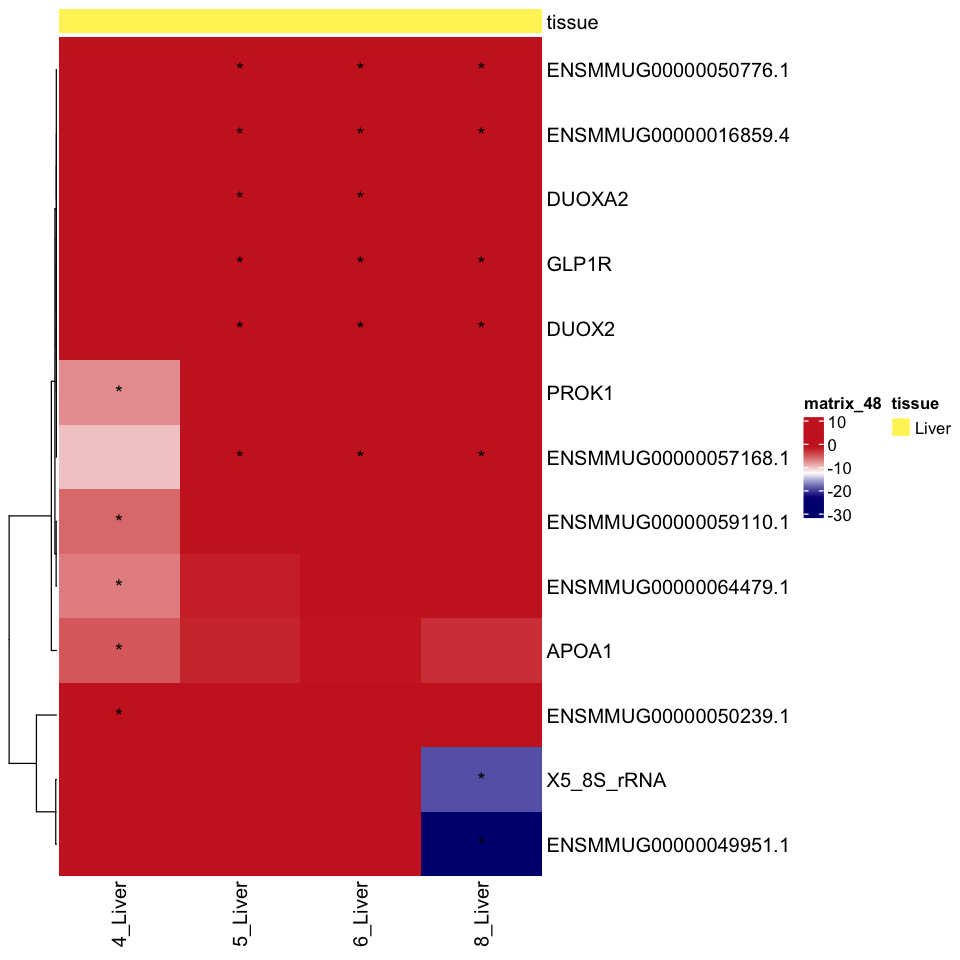

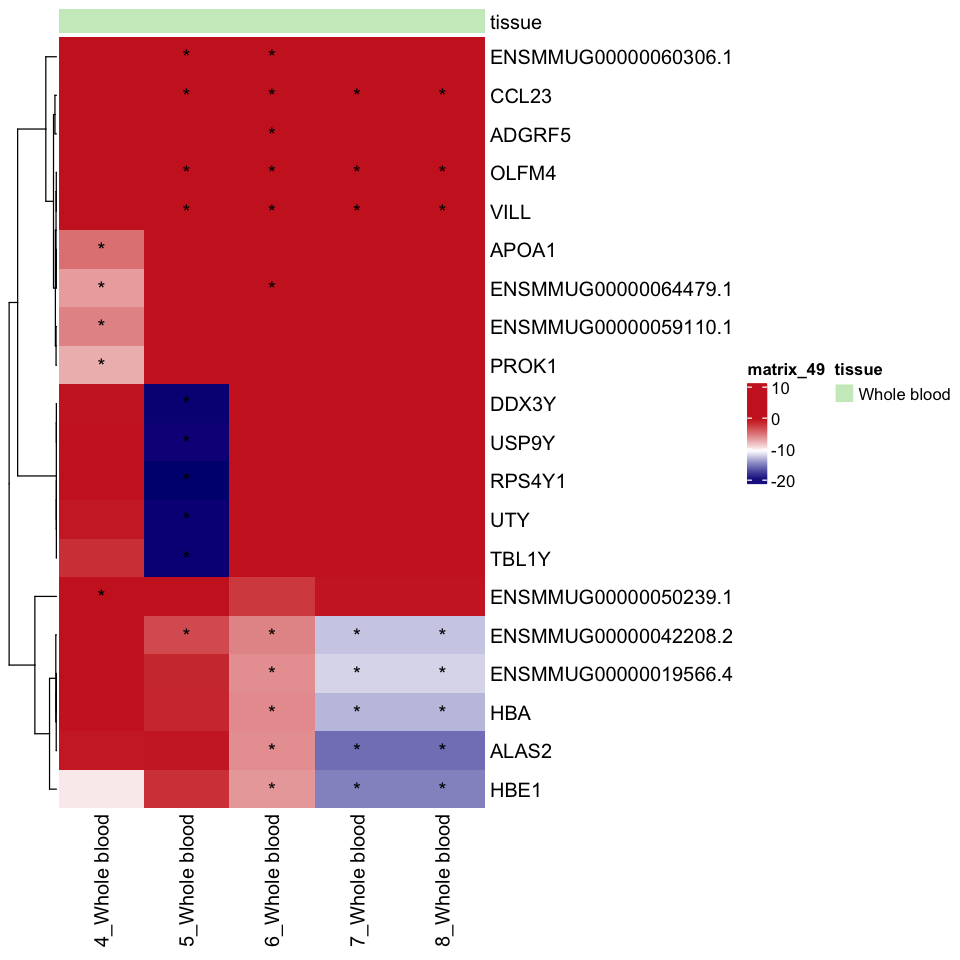

In [282]:
Liver<-PlotsTissue("Liver",3)
WB<-PlotsTissue("Whole blood",3)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

-- replacing outliers and refitting for 182 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Warning message:
“Ignoring unknown aesthetics: label”
Warning message:
“Ignoring unknown aesthetics: label”
Warning message in brewer.pal(n = 100, name = "Blues"):
“n too large, allowed maximum for palette Blues is 9
Returning the palette you asked for with that many colors
”


[1] "This is the current tissue: Brain:Brain-Gr"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersi

[1] "This is the current tissue: Kidney"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`summarise()` has grouped output by 'tissue'. You can override using the
`.groups` argument.
Using padj as value column.  Use the value argument to cast to override this choice



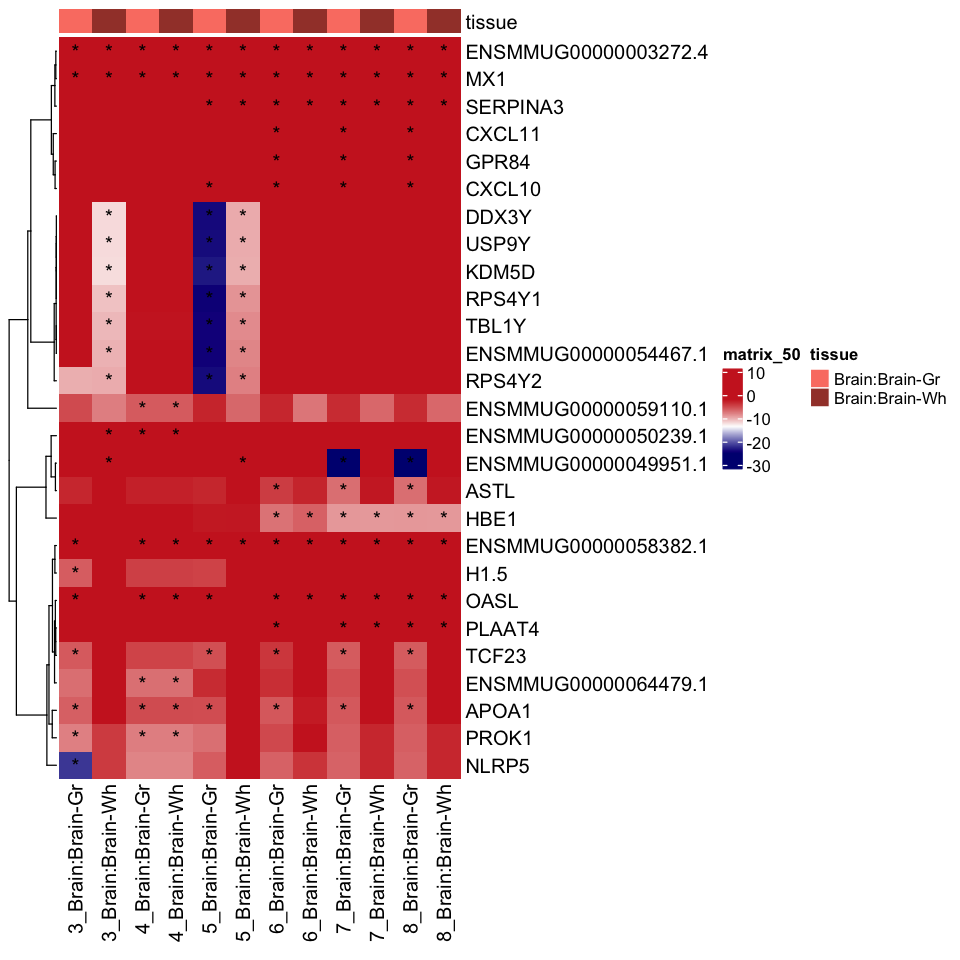

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

-- replacing outliers and refitting for 466 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Warning message:
“Ignoring unknown aesthetics: label”
Warning message:
“Ignoring unknown aesthetics: label”
Warning message in brewer.pal(n = 100, name = "Blues"):
“n too large, allowed maximum for palette Blues is 9
Returning the palette you asked for with that many colors
”


[1] "This is the current tissue: Adrenal Gland"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`summarise()` has grouped output by 'tissue'. You can override using the
`.groups` argument.
Using padj as value column.  Use the value argument to cast to override this choice



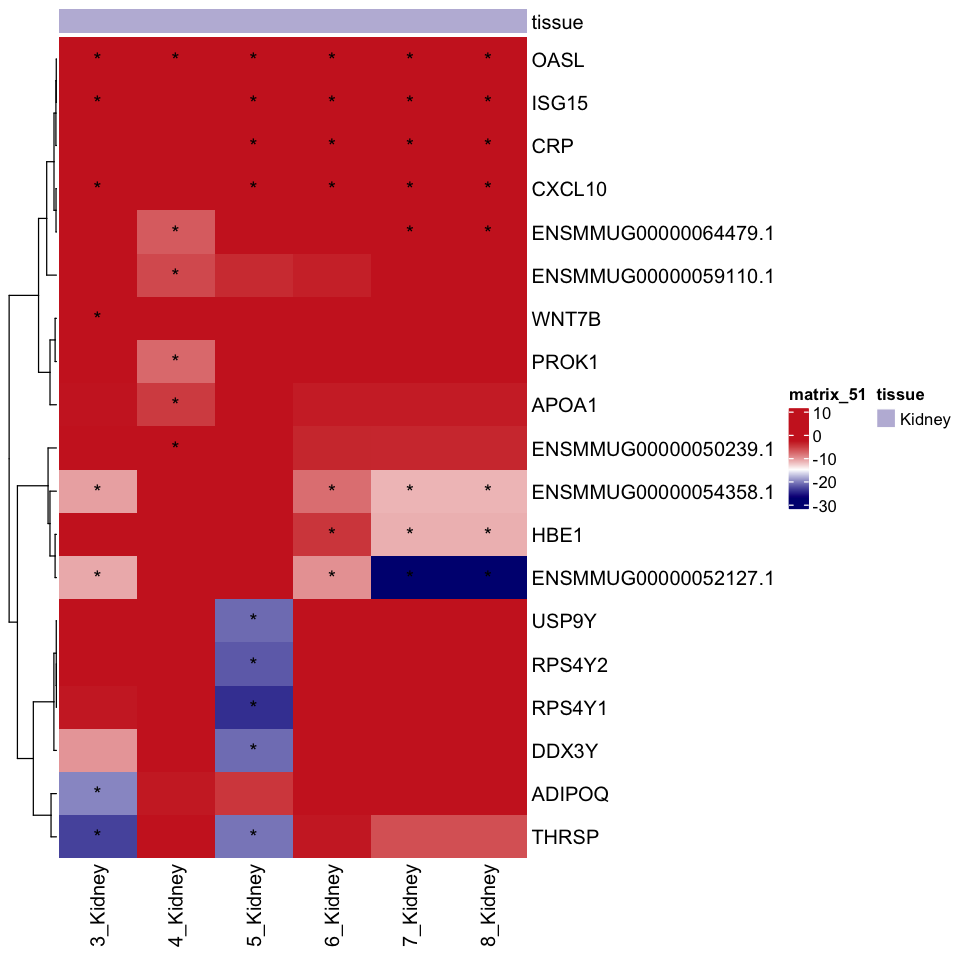

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

-- replacing outliers and refitting for 477 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Warning message:
“Ignoring unknown aesthetics: label”
Warning message:
“Ignoring unknown aesthetics: label”
Warning message in brewer.pal(n = 100, name = "Blues"):
“n too large, allowed maximum for palette Blues is 9
Returning the palette you asked for with that many colors
”


[1] "This is the current tissue: Lymph node:LN-AX-R"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersi

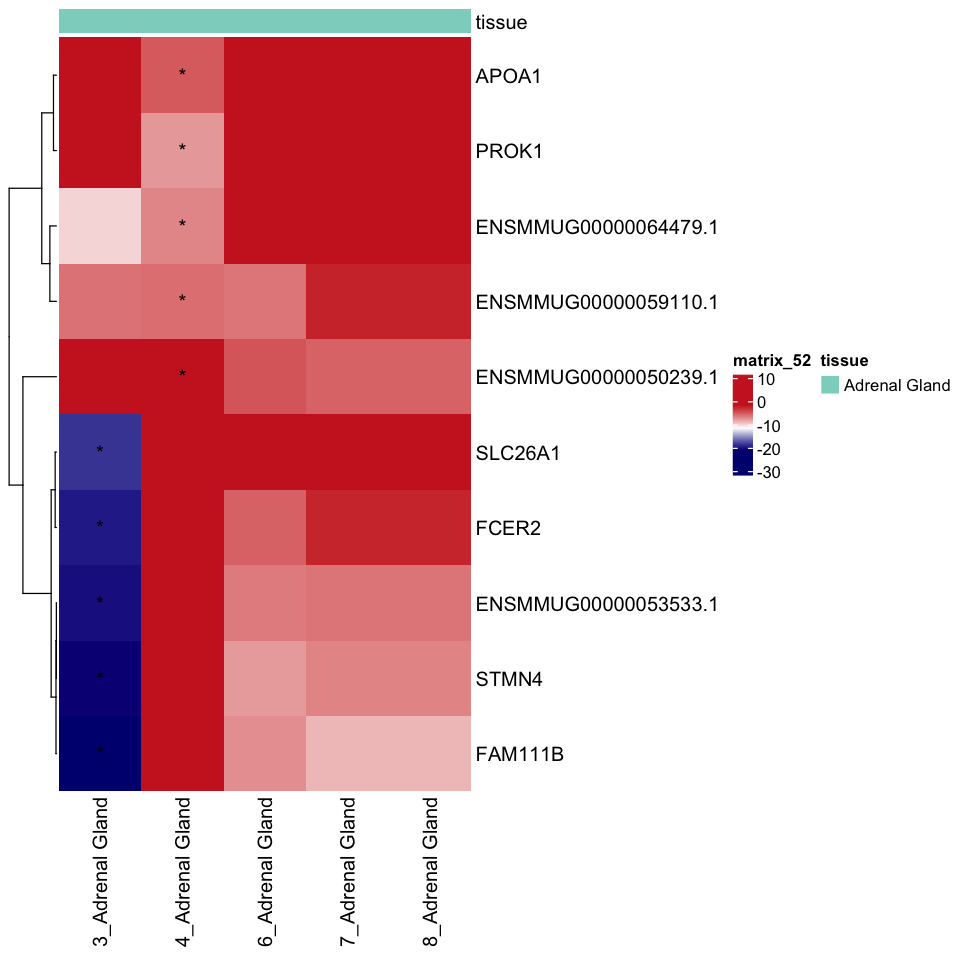

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

-- replacing outliers and refitting for 2037 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Warning message:
“Ignoring unknown aesthetics: label”
Warning message:
“Ignoring unknown aesthetics: label”
Warning message in brewer.pal(n = 100, name = "Blues"):
“n too large, allowed maximum for palette Blues is 9
Returning the palette you asked for with that many colors
”


[1] "This is the current tissue: Sex Organ:Ovary"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersi

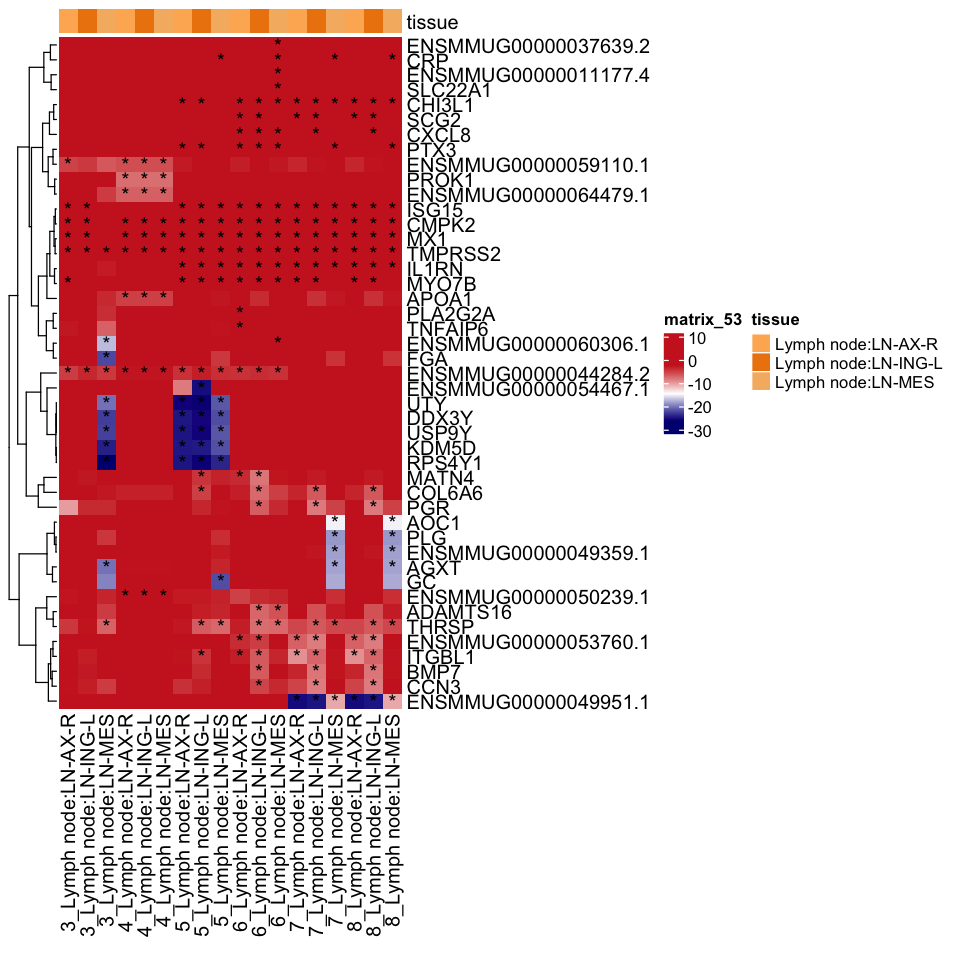

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

-- replacing outliers and refitting for 73 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Warning message:
“Ignoring unknown aesthetics: label”
Warning message:
“Ignoring unknown aesthetics: label”
Warning message in brewer.pal(n = 100, name = "Blues"):
“n too large, allowed maximum for palette Blues is 9
Returning the palette you asked for with that many colors
”


[1] "This is the current tissue: Skin:Rash"


Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

found already estimated gene-wise dispersions, removing these

mean-dispersion relationship

final dispersion estimates

found already estimated dispersions, removing these

fitting model and testing

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Warning message in DESeqDataSet(se.qc.tissue, ~dpi_time_factor):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersi

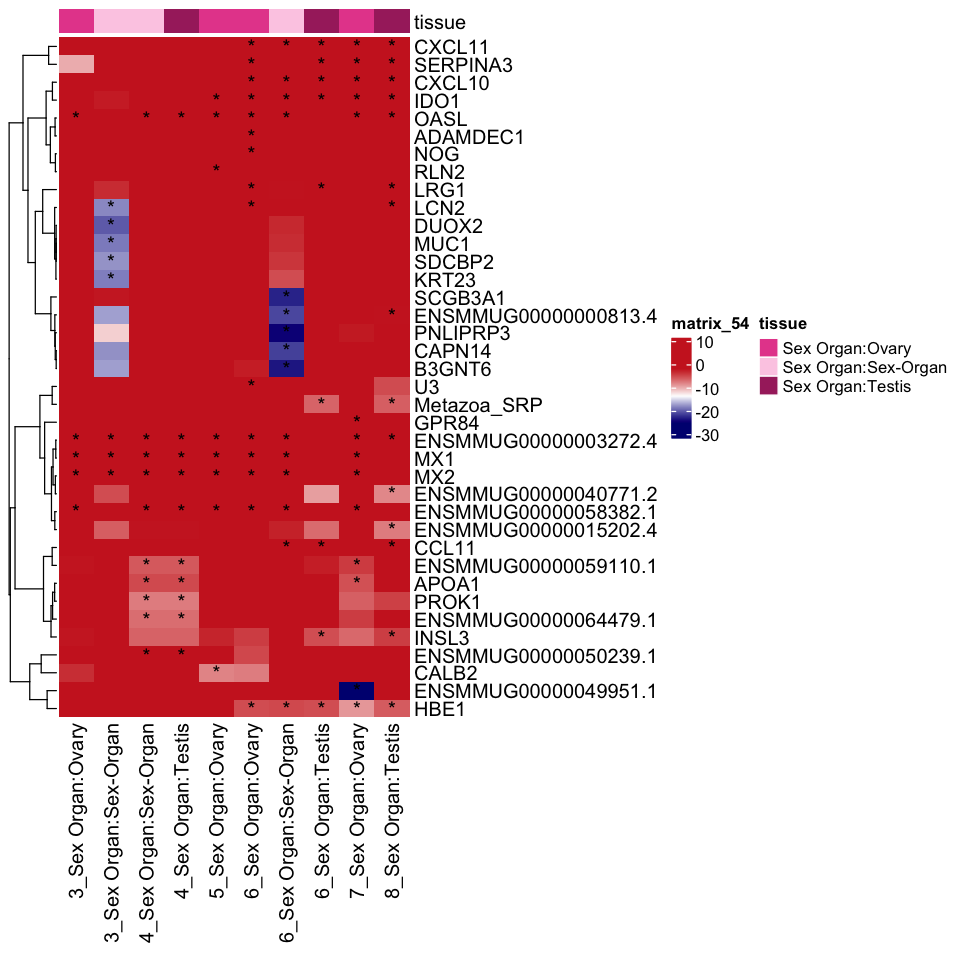

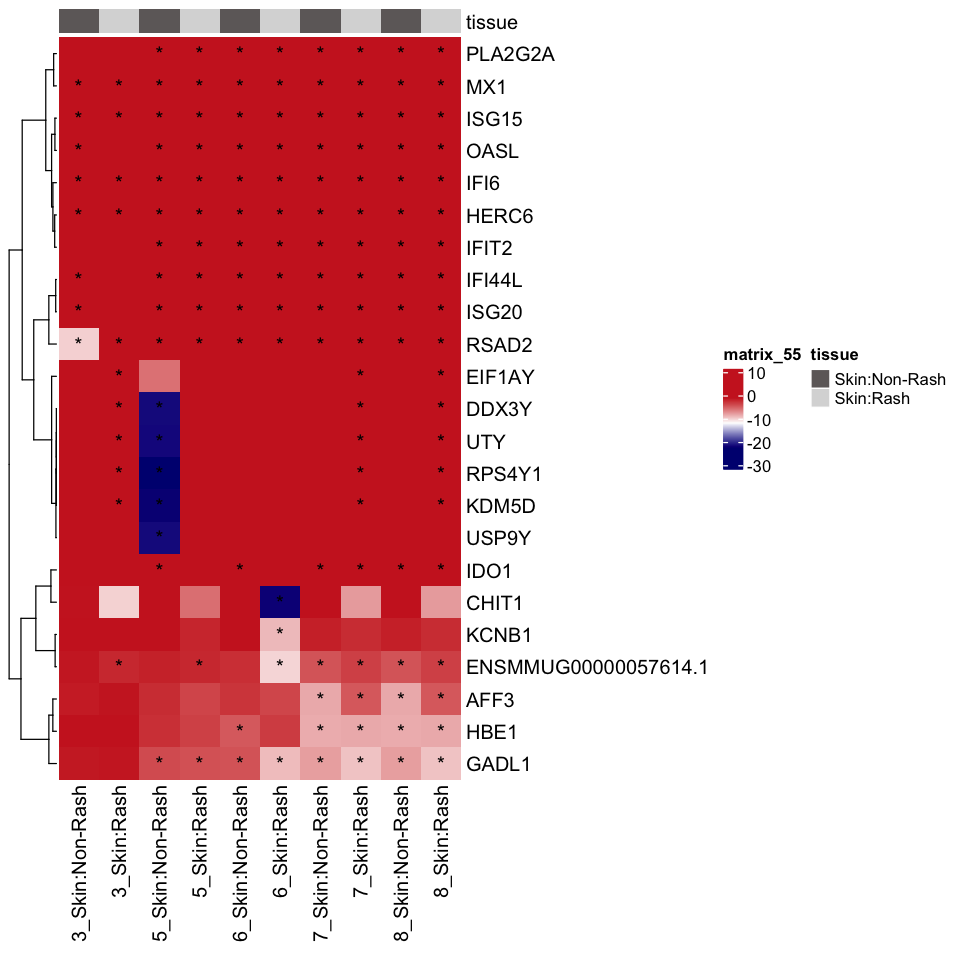

In [283]:
Brain<-PlotsTissue("Brain",0)
Kidney<-PlotsTissue("Kidney",0)
Adrenal<-PlotsTissue("Adrenal Gland",0)
LN<-PlotsTissue("Lymph node",0)
Sex<-PlotsTissue("Sex Organ",0)
Skin<-PlotsTissue("Skin",0)


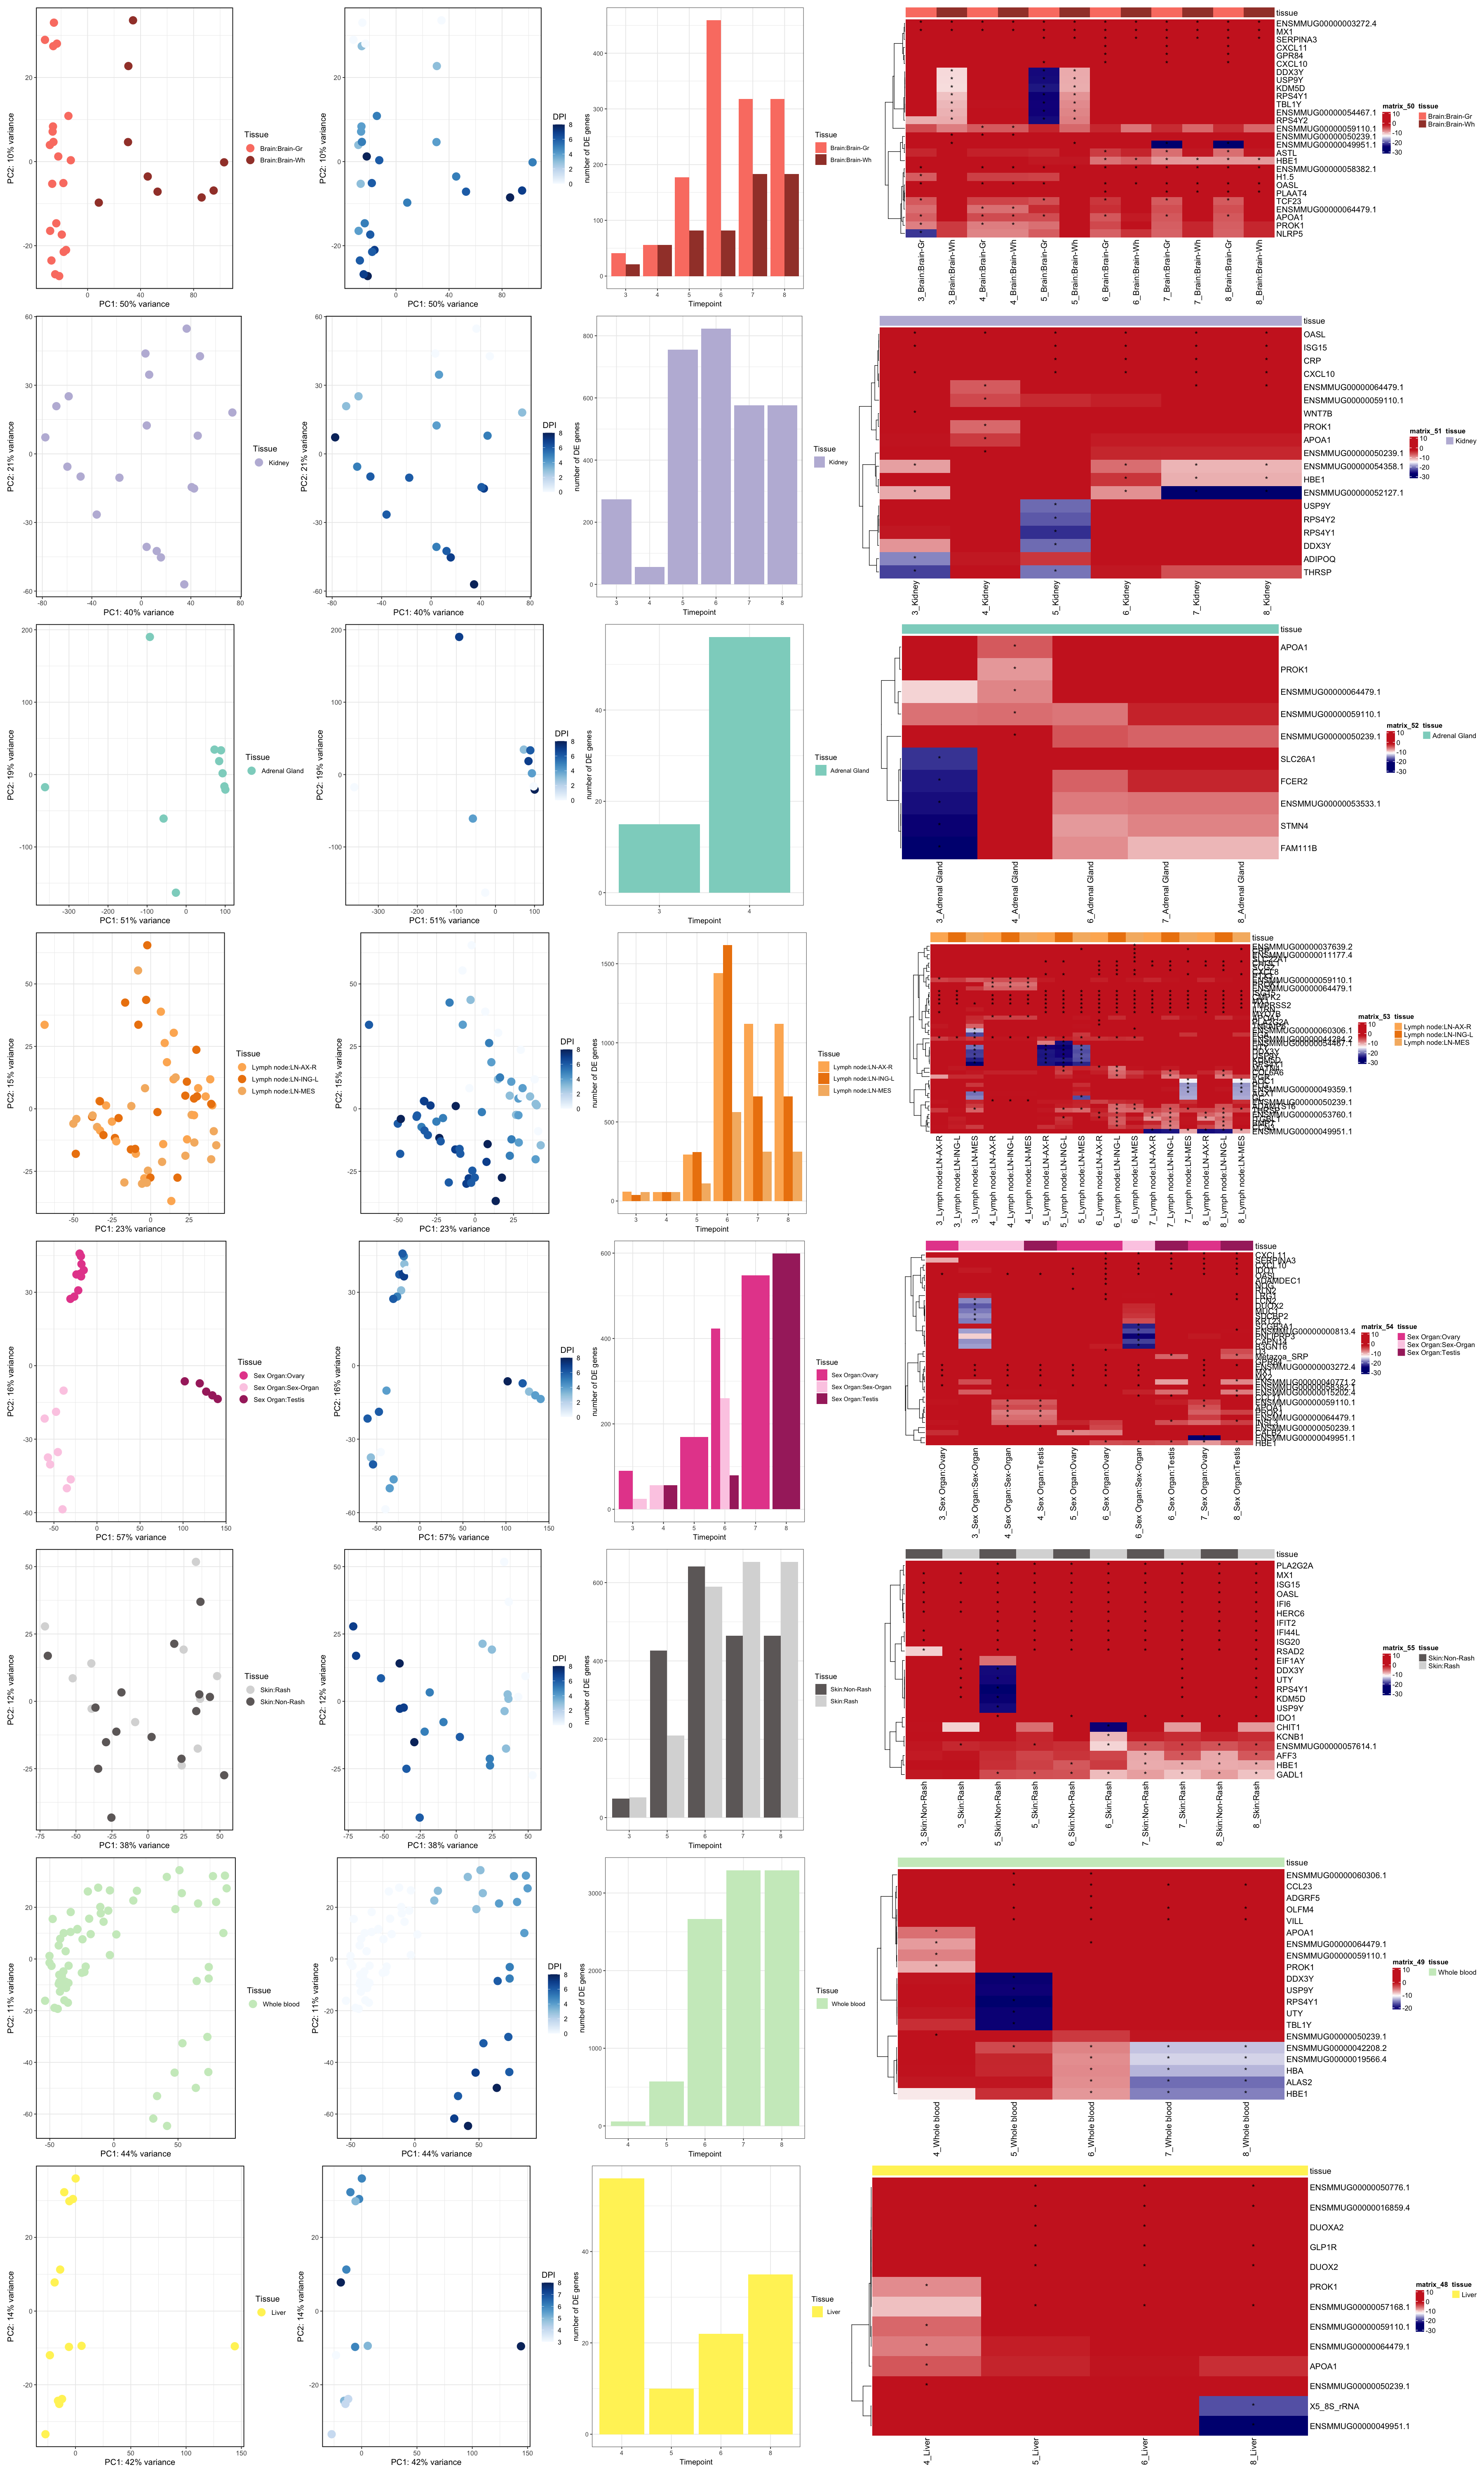

In [294]:
options(repr.plot.width=30,repr.plot.height=50)

Brain/
Kidney/
Adrenal/
LN/
Sex/
Skin/
WB/
Liver


tissue         DPI baseMean   log2FoldChange
ENSMMUG00000015329.4...1      Brain:Brain-Gr tp8 3160.99994 5.428221      
ENSMMUG00000003272.4...2      Brain:Brain-Gr tp8  209.83740 6.232513      
ENSMMUG00000061761.1...3      Brain:Brain-Gr tp8  381.42806 4.941492      
ENSMMUG00000065003.1...4      Brain:Brain-Gr tp8 1019.49458 2.629059      
ENSMMUG00000014755.4...5      Brain:Brain-Gr tp8  862.03386 3.678197      
ENSMMUG00000000769.4...6      Brain:Brain-Gr tp8 1155.77674 4.250519      
ENSMMUG00000012442.4...7      Brain:Brain-Gr tp8  224.46129 3.803794      
ENSMMUG00000010314.4...8      Brain:Brain-Gr tp8  258.63270 3.875036      
ENSMMUG00000001537.4...9      Brain:Brain-Gr tp8  555.44179 3.240286      
ENSMMUG00000005001.4...10     Brain:Brain-Gr tp8  358.04183 5.088247      
ENSMMUG00000008505.4...11     Brain:Brain-Gr tp8  221.78537 4.811682      
ENSMMUG00000046639.2...12     Brain:Brain-Gr tp8 1021.05388 3.349444      
ENSMMUG00000005613.4...13     Brain:Brain-Gr tp8  671.56107 3.280940      
ENSMMUG00000037522.2...14     Brain:Brain-Gr tp8  321.58818 2.878444      
ENSMMUG00000011454.4...15     Brain:Brain-Gr tp8  833.96880 5.138618      
ENSMMUG00000000803.4...16     Brain:Brain-Gr tp8 1435.43066 2.511525      
ENSMMUG00000011301.4...17     Brain:Brain-Gr tp8  375.59622 3.479714      
ENSMMUG00000001880.4...18     Brain:Brain-Gr tp8   95.55842 5.076003      
ENSMMUG00000017533.4...19     Brain:Brain-Gr tp8  248.33858 4.637866      
ENSMMUG00000044257.2...20     Brain:Brain-Gr tp8  260.80419 5.195735      
ENSMMUG00000022569.4...21     Brain:Brain-Gr tp8  251.86753 3.458348      
ENSMMUG00000015332.4...22     Brain:Brain-Gr tp8   88.42434 4.567414      
ENSMMUG00000002350.4...23     Brain:Brain-Gr tp8   67.63763 4.615616      
ENSMMUG00000017563.4...24     Brain:Brain-Gr tp8   64.86725 3.839216      
ENSMMUG00000005455.4...25     Brain:Brain-Gr tp8 4995.88992 2.361301      
ENSMMUG00000058382.1...26     Brain:Brain-Gr tp8   50.62537 6.522819      
ENSMMUG00000010082.4...27     Brain:Brain-Gr tp8  170.79920 2.534902      
ENSMMUG00000016381.4...28     Brain:Brain-Gr tp8  106.06385 3.111607      
ENSMMUG00000005150.4...29     Brain:Brain-Gr tp8  304.31530 4.583689      
ENSMMUG00000001332.4...30     Brain:Brain-Gr tp8  183.83798 3.266073      
⋮                             ⋮              ⋮   ⋮          ⋮             
ENSMMUG00000053951.1...424711 Brain:Brain-Wh tp3 2.95080370  0.5419579    
ENSMMUG00000061076.1...424712 Brain:Brain-Wh tp3 0.79340263  0.6415367    
ENSMMUG00000064065.1...424713 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000064655.1...424714 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000059962.1...424715 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000061317.1...424716 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000035418.3...424717 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000058819.1...424718 Brain:Brain-Wh tp3 1.00495101 -4.1228449    
ENSMMUG00000032007.3...424719 Brain:Brain-Wh tp3 0.00000000  0.0000000    
ENSMMUG00000053315.1...424720 Brain:Brain-Wh tp3 0.31511391  0.7620522    
ENSMMUG00000064027.1...424721 Brain:Brain-Wh tp3 0.18374058  0.7620475    
ENSMMUG00000059394.1...424722 Brain:Brain-Wh tp3 0.51758493  3.0838229    
ENSMMUG00000051421.1...424723 Brain:Brain-Wh tp3 0.11051965  0.7621401    
ENSMMUG00000051083.1...424724 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000053226.1...424725 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000050029.1...424726 Brain:Brain-Wh tp3 0.39586620 -5.1225793    
ENSMMUG00000063640.1...424727 Brain:Brain-Wh tp3 0.61684328 -0.6803466    
ENSMMUG00000064166.1...424728 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000063841.1...424729 Brain:Brain-Wh tp3 1.45128565  1.3196209    
ENSMMUG00000061620.1...424730 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000056295.1...424731 Brain:Brain-Wh tp3 0.00000000         NA    
ENSMMUG00000053892.1...424732 Brain:Brain-Wh tp3 2.8040

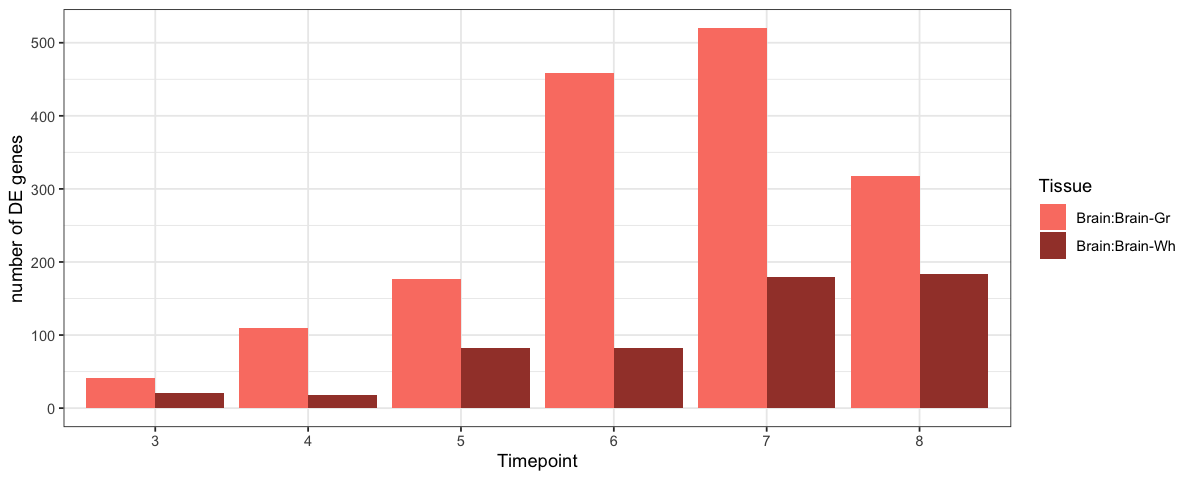

In [254]:
GenesDE

`summarise()` has grouped output by 'tissue'. You can override using the
`.groups` argument.


tissue         DPI count
1  Brain:Brain-Gr 3    41  
2  Brain:Brain-Gr 4   109  
3  Brain:Brain-Gr 5   177  
4  Brain:Brain-Gr 6   459  
5  Brain:Brain-Gr 7   520  
6  Brain:Brain-Gr 8   318  
7  Brain:Brain-Wh 3    21  
8  Brain:Brain-Wh 4    18  
9  Brain:Brain-Wh 5    82  
10 Brain:Brain-Wh 6    82  
11 Brain:Brain-Wh 7   180  
12 Brain:Brain-Wh 8   183

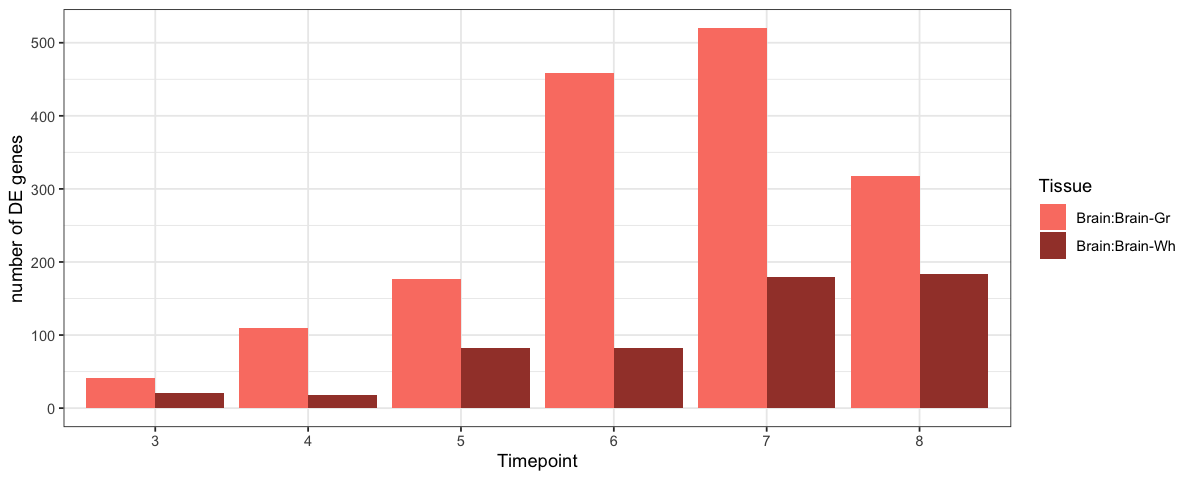

In [178]:
table(de.genes.Infection$DPI)



    3     4     5     6     7     8 
70790 70790 70790 70790 70790 70790 

Gene                 3_Brain:Brain-Gr 3_Brain:Brain-Wh 4_Brain:Brain-Gr
1  ENSMMUG00000001442.4  -5.98141564       2.76208247      -3.9478168     
2  ENSMMUG00000003272.4   3.08376985       4.76798961       3.7506609     
3  ENSMMUG00000006441.4   3.40805926       6.54337002       4.6643366     
4  ENSMMUG00000006868.4   1.30328093       0.00000000       5.2190480     
5  ENSMMUG00000008505.4   2.78392807       5.27606169       3.7911987     
6  ENSMMUG00000008941.4  -3.65360179      -0.09547595      -5.3065423     
7  ENSMMUG00000011218.4  -0.97887489       2.95617117       2.1066110     
8  ENSMMUG00000015329.4   2.58701553       4.24797854       3.9337020     
9  ENSMMUG00000015332.4   2.06842431       4.73456848       3.6449749     
10 ENSMMUG00000016064.4  -0.38512934      -2.06792987      -0.7827130     
11 ENSMMUG00000016671.3   1.75538216       3.08400702       3.7176103     
12 ENSMMUG00000020903.3   0.79500914       0.00000000       4.5262681     
13 ENSMMUG00000022437.4  -4.78607523       1.76198118      -5.7216706     
14 ENSMMUG00000028710.3 -21.81491205      -4.12276272     -22.4824530     
15 ENSMMUG00000038331.2   0.03444562     -10.87794748       0.6853127     
16 ENSMMUG00000038824.2   0.33719119      -9.90441641       0.7438121     
17 ENSMMUG00000041831.2  -0.92437561      -0.05717172      -0.8262882     
18 ENSMMUG00000043966.2   0.45219065     -11.95595194       1.3362879     
19 ENSMMUG00000044545.2  -6.17168895      -0.09543955      -4.9428201     
20 ENSMMUG00000045017.2   0.03551819     -12.04191951       0.9179006     
21 ENSMMUG00000045105.2   1.15424066       6.69276709       1.5871009     
22 ENSMMUG00000045991.2   0.36305836     -11.99957803       1.2591836     
23 ENSMMUG00000046495.2  -1.19244067     -10.42683647       1.1420592     
24 ENSMMUG00000049951.1  -0.09921496      11.94635075      -1.3750206     
25 ENSMMUG00000050239.1   3.37466183      11.31380155      -1.2895972     
26 ENSMMUG00000053130.1   2.83562023       2.34703027       5.5631608     
27 ENSMMUG00000054467.1  -0.63327559     -10.16744172       1.0017806     
28 ENSMMUG00000056872.1  -5.84625929      -1.02835728      -3.9947704     
29 ENSMMUG00000058382.1   3.18755025       7.02880004       4.1390207     
30 ENSMMUG00000059018.1  -1.28998352      -3.55489015      -1.5327361     
31 ENSMMUG00000060920.1  -3.01128669      -0.26520574      -2.2304679     
32 ENSMMUG00000064173.1  -7.76448125      -4.12296262      -7.4198317     
   4_Brain:Brain-Wh 5_Brain:Brain-Gr 5_Brain:Brain-Wh 6_Brain:Brain-Gr
1   0.00000000       -4.5518394       1.32436565       0.36818090     
2   5.13094103        4.7071740       5.97890082       6.22622366     
3   6.45794453        4.7776307       8.14591458       5.09174271     
4   3.65062704        5.6986771       5.25822392       4.43462643     
5   5.21710904        4.6210126       6.12134604       4.90946653     
6  -0.37681984       -4.5976736      -2.55521861      -0.40896734     
7   4.30615821        5.7633090       6.43449474       4.74534653     
8   4.93901272        4.9946797       5.82985144       5.86855552     
9   5.16230704        4.4912885       5.93787095       5.12040679     
10 -2.43568931        0.2673021      -2.85214195      -0.91787546     
11  0.00000000        4.8243543       5.43286959       5.48023612     
12  2.65065590        5.5719066       6.33272374       6.08122204     
13  0.00000000       -4.0041265       2.67659681      -5.47026457     
14  0.20840453       -6.0248368       0.60043648      -6.25158441     
15  0.53009152      -24.5551639      -8.75235393      -0.37853851     
16  0.69359539      -24.0203279      -7.77882161       0.03106688     
17 -1.22245743       -2.2036778      -2.11220997      -7.11093721     
18  0.68815147      -24.0311614      -9.83036026       0.57055806     
19  1.53009725       -5.1279626       0.46908925      -5.69062420     
20 -0.30130901      -23.4248268      -9.91632874      -0.01757140     
21  5.97253725        1.5055022      

Using padj as value column.  Use the value argument to cast to override this choice



ENSMMUG00000001442.4   ENSMMUG00000003272.4   ENSMMUG00000006441.4 
                "H1-5" "ENSMMUG00000003272.4"                 "OASL" 
  ENSMMUG00000006868.4   ENSMMUG00000008505.4   ENSMMUG00000008941.4 
              "S100A9"                 "OAS2"                "TOP2A" 
  ENSMMUG00000011218.4   ENSMMUG00000015329.4   ENSMMUG00000015332.4 
            "SERPINA3"                  "MX1"              "TMPRSS2" 
  ENSMMUG00000016064.4   ENSMMUG00000016671.3   ENSMMUG00000020903.3 
               "C1QL3"                "GPR84"               "CXCL10" 
  ENSMMUG00000022437.4   ENSMMUG00000028710.3   ENSMMUG00000038331.2 
               "PADI6"                "NLRP5"               "RPS4Y1" 
  ENSMMUG00000038824.2   ENSMMUG00000041831.2   ENSMMUG00000043966.2 
              "RPS4Y2"                 "HBE1"                "DDX3Y" 
  ENSMMUG00000044545.2   ENSMMUG00000045017.2   ENSMMUG00000045105.2 
               "APOA1"                "KDM5D"               "PLAAT4" 
  ENSMMUG00000045991.2   ENSMMUG00000046495.2   ENSMMUG00000049951.1 
               "USP9Y"                "TBL1Y" "ENSMMUG00000049951.1" 
  ENSMMUG00000050239.1   ENSMMUG00000053130.1   ENSMMUG00000054467.1 
"ENSMMUG00000050239.1"               "CXCL11" "ENSMMUG00000054467.1" 
  ENSMMUG00000056872.1   ENSMMUG00000058382.1   ENSMMUG00000059018.1 
               "TCF23" "ENSMMUG00000058382.1" "ENSMMUG00000059018.1" 
  ENSMMUG00000060920.1   ENSMMUG00000064173.1 
                "ASTL"                "PROK1"

3_Brain:Brain-Gr 3_Brain:Brain-Wh 4_Brain:Brain-Gr
H1.5                 1                0                0               
ENSMMUG00000003272.4 1                1                1               
OASL                 1                0                1               
S100A9               0                0                1               
OAS2                 1                1                1               
TOP2A                0                0                1               
                     4_Brain:Brain-Wh 5_Brain:Brain-Gr 5_Brain:Brain-Wh
H1.5                 0                0                0               
ENSMMUG00000003272.4 1                1                1               
OASL                 0                1                0               
S100A9               0                1                0               
OAS2                 1                1                1               
TOP2A                0                0                0               
                     6_Brain:Brain-Gr 6_Brain:Brain-Wh 7_Brain:Brain-Gr
H1.5                 0                0                0               
ENSMMUG00000003272.4 1                1                1               
OASL                 1                1                1               
S100A9               1                0                0               
OAS2                 1                1                1               
TOP2A                0                0                0               
                     7_Brain:Brain-Wh 8_Brain:Brain-Gr 8_Brain:Brain-Wh
H1.5                 0                0                0               
ENSMMUG00000003272.4 1                1                1               
OASL                 1                1                1               
S100A9               0                0                0               
OAS2                 1                1                1               
TOP2A                0                0                0

[1] "3_Brain:Brain-Gr" "3_Brain:Brain-Wh" "4_Brain:Brain-Gr" "4_Brain:Brain-Wh"
 [5] "5_Brain:Brain-Gr" "5_Brain:Brain-Wh" "6_Brain:Brain-Gr" "6_Brain:Brain-Wh"
 [9] "7_Brain:Brain-Gr" "7_Brain:Brain-Wh" "8_Brain:Brain-Gr" "8_Brain:Brain-Wh"

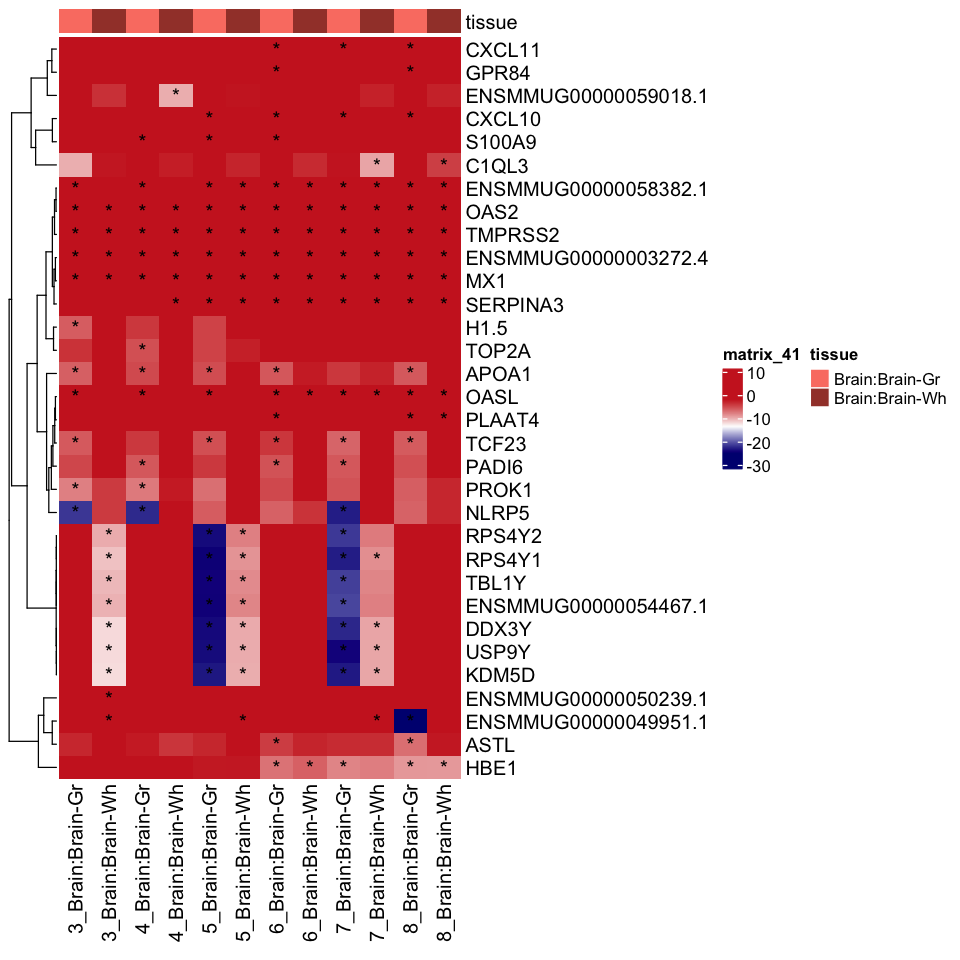

In [12]:
ggsave('output/brain_overview_time.png',w=8,h=8)

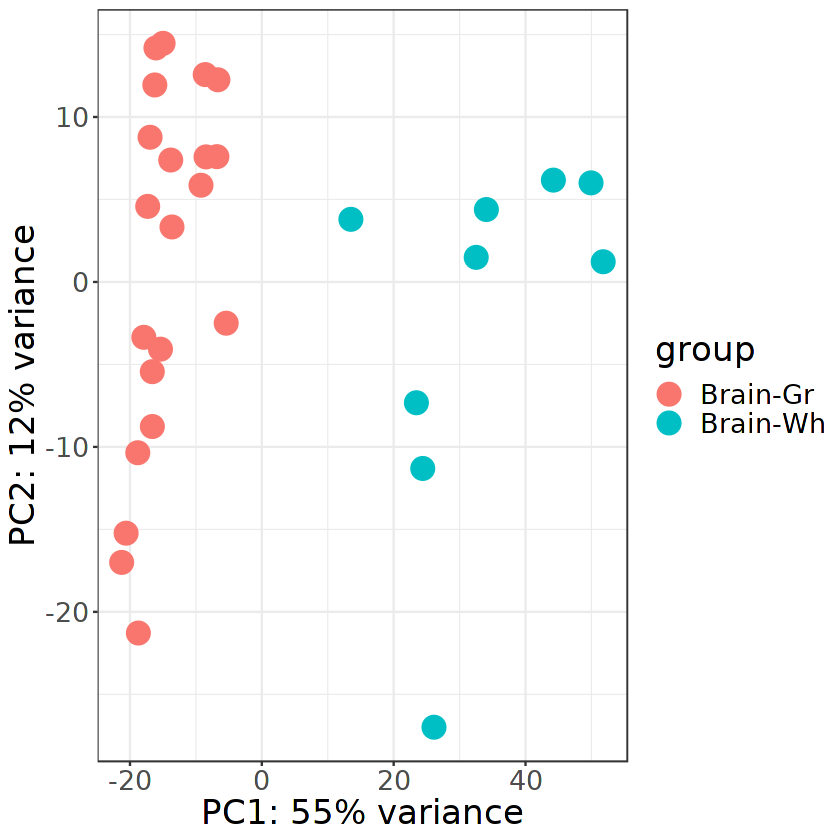

In [13]:
customPlotPCA(rld,intgroup='sub.tissue',returnData=TRUE) -> plot.df

percentVar <- attr(plot.df, "percentVar")

plot.df %>% ggplot(ggplot2::aes_string(x = "PC1", 
        y = "PC2", color = "group")) + ggplot2::geom_point(size = 6) +
        theme_bw() + 
        ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) +
        ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +
        theme(text = element_text(size=20)) 

In [14]:
ggsave('output/brain_overview_subtissue.png',w=8,h=8)

## Load the results for White and Gray 

In [15]:
brain_de_filepaths <- c(
    brain_gray = "/home/nbarkas/disk2/ebov_bulk_rna_seq/proc_20210329/08-simple-de-by-tissue/08-Brain_Brain-Gr/output/BrainGray.de.csv",
    brain_white = "/home/nbarkas/disk2/ebov_bulk_rna_seq/proc_20210329/08-simple-de-by-tissue/16-Brain_Brain-Wh/output/Brain_White.de.csv"
)

In [16]:
brain_de <- lapply(brain_de_filepaths, read.csv)

In [17]:
# inspect
brain_de[[1]][1:3,]

X                    baseMean log2FoldChange lfcSE     stat      pvalue      
1 ENSMMUG00000044257.2 464.4289 4.769676       0.4221340 11.298960 1.327816e-29
2 ENSMMUG00000008505.4 394.2692 4.393440       0.4648780  9.450739 3.364480e-21
3 ENSMMUG00000002350.4 121.4725 3.773450       0.4672421  8.076006 6.692259e-16
  padj         Geneid              
1 2.730122e-25 ENSMMUG00000044257.2
2 3.458854e-17 ENSMMUG00000008505.4
3 4.586651e-12 ENSMMUG00000002350.4
  Chr                                                                                                                                                                                                                                                                                                                                                                                                                      
1 chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3
2 chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11                                                                                                                                                                                                                                                                                            
3 chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1                                                                                                                                                                                                                                                                                                                                     
  Start                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1 5231302;5231576;5231577;5231577;5232000;5233249;5233249;5233249;5233249;5233249;5235185;5236823;5236823;5236823;5236823;5236823;5236823;5238037;5238037;5238037;5238037;5238037;5238037;5241060;5241060;5241060;5241060;5241060;5241060;5241353;5241353;5241353;5241353;5241353;5241353;5243969;5243969;5243969;5243969;5243969;5243969;5245827;5245827;5245827;5245827;5245827;5245827;5250866;5250866;5250866;5250866;5250866;5250866;5257257;5257257;5257257;5257257;5257257;5257257;5258397;5258397;5258397;5258397;5258397;5260412;5260416;5260416;5260416;5260416;5260416;5261243;5261243;5261243;5261243;5261243;5261243;5265398;5268930;5270079;5275321;5275321;5275321
2 112695427;112695570;112704196;112704196;112712721;112712721;112714961;112714961;112715711;112715711;112720029;112720029;112721980;112721980;112723463;112723463;112724645;112724645;112726018;112726018;112727279                                                                                                                                                                                                                                                                                                                                                                           

In [18]:
# Get singificant genes for each
brain_de_genes <- lapply(brain_de, function(x) { x[NA2FALSE(x$padj < 0.05),]$X })

In [19]:
# How many
lapply(brain_de_genes, length)

$brain_gray
[1] 296

$brain_white
[1] 71

(polygon[GRID.polygon.315], polygon[GRID.polygon.316], polygon[GRID.polygon.317], polygon[GRID.polygon.318], text[GRID.text.319], text[GRID.text.320], text[GRID.text.321], text[GRID.text.322], text[GRID.text.323]) 

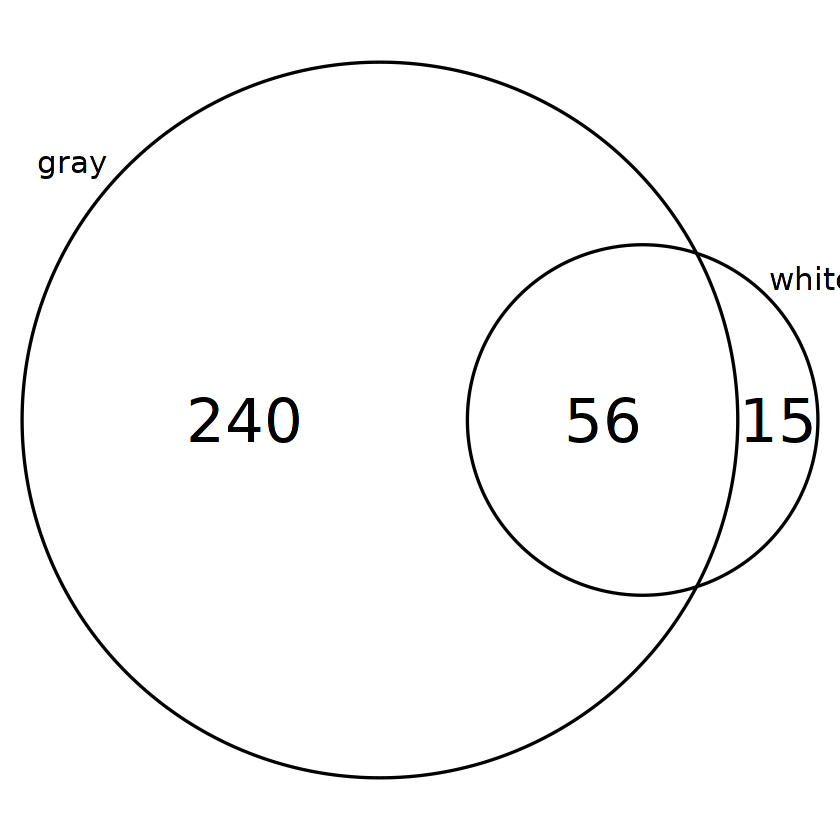

In [20]:
# Draw a Venn Diagram of the overlap between the two
draw.double.venn.fromVectors(
    brain_de_genes$brain_gray,
    brain_de_genes$brain_white,
    category=c('gray','white'),
    cex=3, cat.cex=1.5
)

In [21]:
png('output/brain_de_venn.png')
draw.double.venn.fromVectors(
    brain_de_genes$brain_gray,
    brain_de_genes$brain_white,
    category=c('gray','white'),
    cex=3, cat.cex=1.5
)
dev.off()

(polygon[GRID.polygon.324], polygon[GRID.polygon.325], polygon[GRID.polygon.326], polygon[GRID.polygon.327], text[GRID.text.328], text[GRID.text.329], text[GRID.text.330], text[GRID.text.331], text[GRID.text.332]) 

png 
  2

In [22]:
# Get genes exclusive to each tissue
gray.excl <- setdiff(brain_de_genes$brain_gray, brain_de_genes$brain_white)
white.excl <- setdiff(brain_de_genes$brain_white, brain_de_genes$brain_gray)

In [23]:
# Plot the gray exclusive genes
plot.df <- data.frame(
    gene.name = gray.excl,
    white.fc = brain_de$brain_white[brain_de$brain_white$X %in% gray.excl,]$log2FoldChange,
    gray.fc = brain_de$brain_gray[brain_de$brain_gray$X %in% gray.excl,]$log2FoldChange)

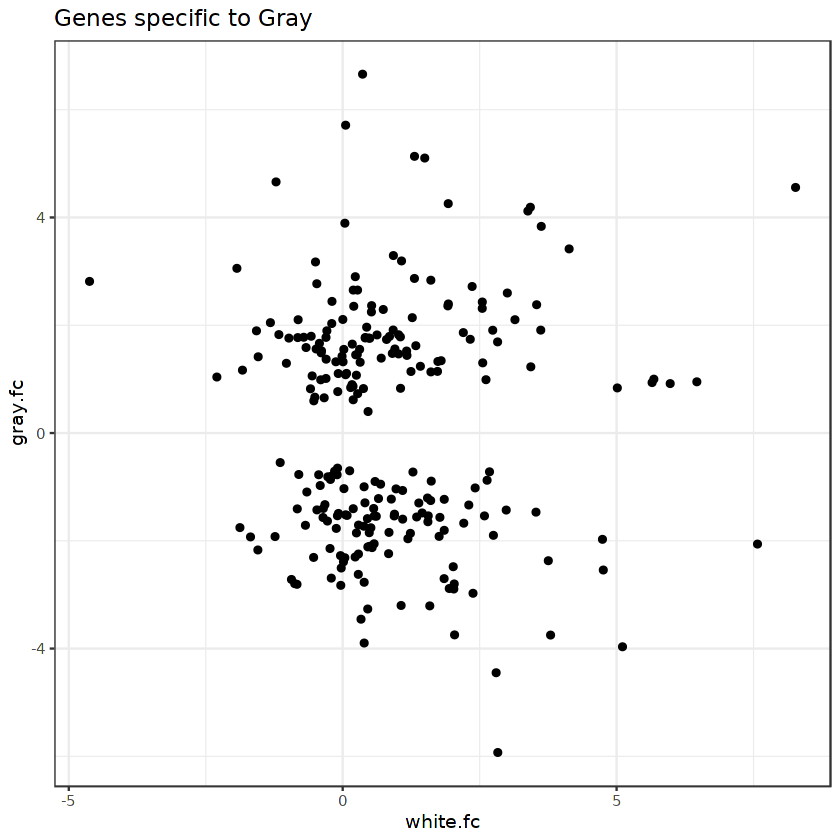

In [24]:
ggplot(plot.df, aes(x=white.fc,y=gray.fc)) + 
    geom_point() + 
    theme_bw() +
    ggtitle('Genes specific to Gray')

In [25]:
ggsave('output/gray_specific_genes.png',w=7,h=7)

# Split the above into up and down (in Gray)

In [26]:
# Look at genes down in white but up in gray
plot.df %>% filter(white.fc < 0 & gray.fc > 0) %>% pull(gene.name) -> up_gray_down_white_genes

Warning message in pcls(G):
“initial point very close to some inequality constraints”
Warning message:
“replacing previous import ‘Rcpp::prompt’ by ‘utils::prompt’ when loading ‘nbHelpers’”
Warning message:
“replacing previous import ‘Rcpp::.DollarNames’ by ‘utils::.DollarNames’ when loading ‘nbHelpers’”
Warning message:
“replacing previous import ‘Matrix::tail’ by ‘utils::tail’ when loading ‘nbHelpers’”
Warning message:
“replacing previous import ‘Matrix::head’ by ‘utils::head’ when loading ‘nbHelpers’”
Using manually entered categories.

For 25030 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



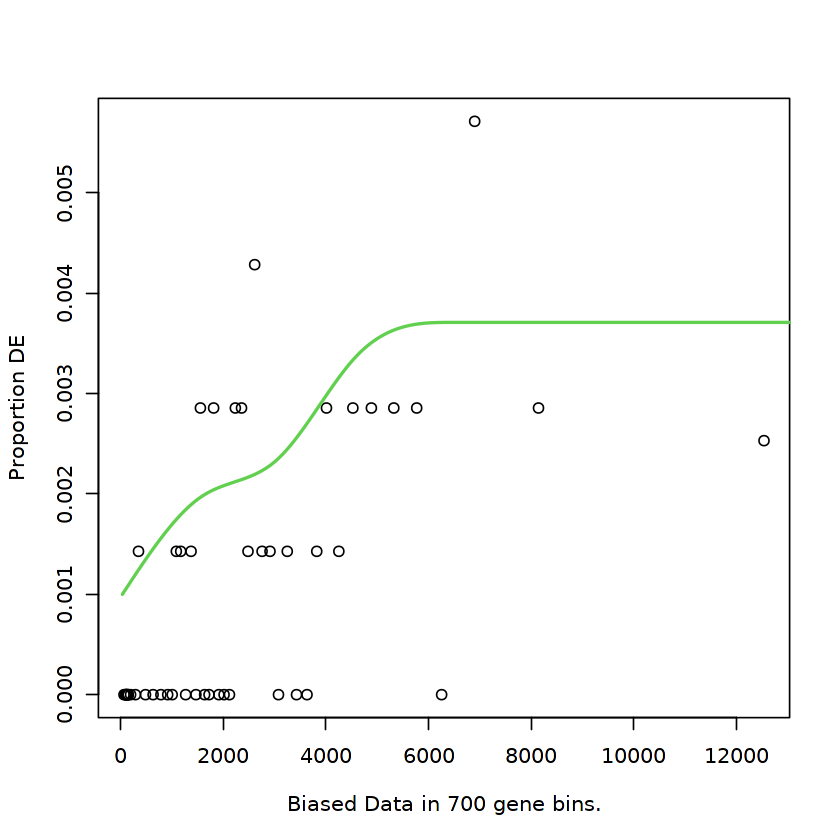

In [27]:
# run GO with just these genes
genes <- brain_de$brain_gray$X %in% up_gray_down_white_genes
names(genes) <- brain_de$brain_gray$X
genes <- genes[!is.na(genes)]

gene.lengths <- brain_de$brain_gray$Length
names(gene.lengths) <- brain_de$brain_gray$X

gl <- gene.lengths[names(genes)]

pwf <- nullp(genes, "rheMac10", "ensGene", bias.data = gene.lengths[names(genes)])

rownames(pwf) <- nbHelpers::strpart(rownames(pwf), ".", 1, fixed = T)

gene2cat <- getgo(genes = nbHelpers::strpart(names(genes), 
        split = ".", fixed = T, n = 1), genome = "rheMac10", 
        id = "ensGene", fetch.cats = c("GO:CC", "GO:BP", "GO:MF"))

goseq_res1 <- goseq::goseq(pwf = pwf, genome = "rheMac10", gene2cat = gene2cat, test.cats = c("GO:CC", "GO:BP", "GO:MF"))

In [28]:
head(goseq_res1,n=10)

category   over_represented_pvalue under_represented_pvalue numDEInCat
7738  GO:0035325 8.756394e-05            0.9999997                2         
2862  GO:0006955 1.725956e-04            0.9999842                6         
12189 GO:0070231 3.663314e-04            0.9999973                2         
10990 GO:0051707 6.304507e-04            0.9999414                5         
8792  GO:0043207 6.423141e-04            0.9999401                5         
810   GO:0002376 6.869292e-04            0.9999034                7         
3683  GO:0009607 6.899018e-04            0.9999346                5         
12185 GO:0070227 8.005473e-04            0.9999908                2         
7834  GO:0035606 9.722671e-04            1.0000000                1         
3174  GO:0008112 1.411388e-03            1.0000000                1         
      numInCat term                                      ontology
7738    8      Toll-like receptor binding                MF      
2862  458      immune response                           BP      
12189  13      T cell apoptotic process                  BP      
10990 385      response to other organism                BP      
8792  387      response to external biotic stimulus      BP      
810   807      immune system process                     BP      
3683  394      response to biotic stimulus               BP      
12185  20      lymphocyte apoptotic process              BP      
7834    1      peptidyl-cysteine S-trans-nitrosylation   BP      
3174    1      nicotinamide N-methyltransferase activity MF

In [29]:
## Continue from here look at these pathways in White and Gray

# Go analysis of common brain genes

In [30]:
brain_node_common <- Reduce(intersect, brain_de_genes)

In [31]:
z <- unique(rowData(se.qc.tissue)$external_gene_name[match(brain_node_common,rowData(se.qc.tissue)$Geneid)])
z <- z[z!='']

In [32]:
res_tmp <- results(dds_simple)

In [33]:
res_tmp <- post_process_res(res_tmp,se.qc.tissue)

In [34]:
# res only used for gene lengths
runMacaqueGO_custom <- function(res,  gene_list, test.cats = c("GO:CC", "GO:BP", "GO:MF")) {
    genes <- as.integer(rownames(res) %in% gene_list)
    names(genes) <- rownames(res)
    genes <- genes[!is.na(genes)]
    #print(genes)
    
    gene.lengths <- res$Length
    names(gene.lengths) <- rownames(res)
    
    pwf <- nullp(genes, "rheMac10", "ensGene", bias.data = gene.lengths[names(genes)])
    
    
    rownames(pwf) <- nbHelpers::strpart(rownames(pwf), ".", 1, fixed = T)
    
    gene2cat <- getgo(genes = nbHelpers::strpart(names(genes), 
        split = ".", fixed = T, n = 1), genome = "rheMac10", 
        id = "ensGene", fetch.cats = test.cats)
    
    goseq_res1 <- goseq::goseq(pwf = pwf, genome = "rheMac10", gene2cat = gene2cat, 
        test.cats = test.cats)
    
    invisible(goseq_res1)
}

Warning message in pcls(G):
“initial point very close to some inequality constraints”
Using manually entered categories.

For 25030 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



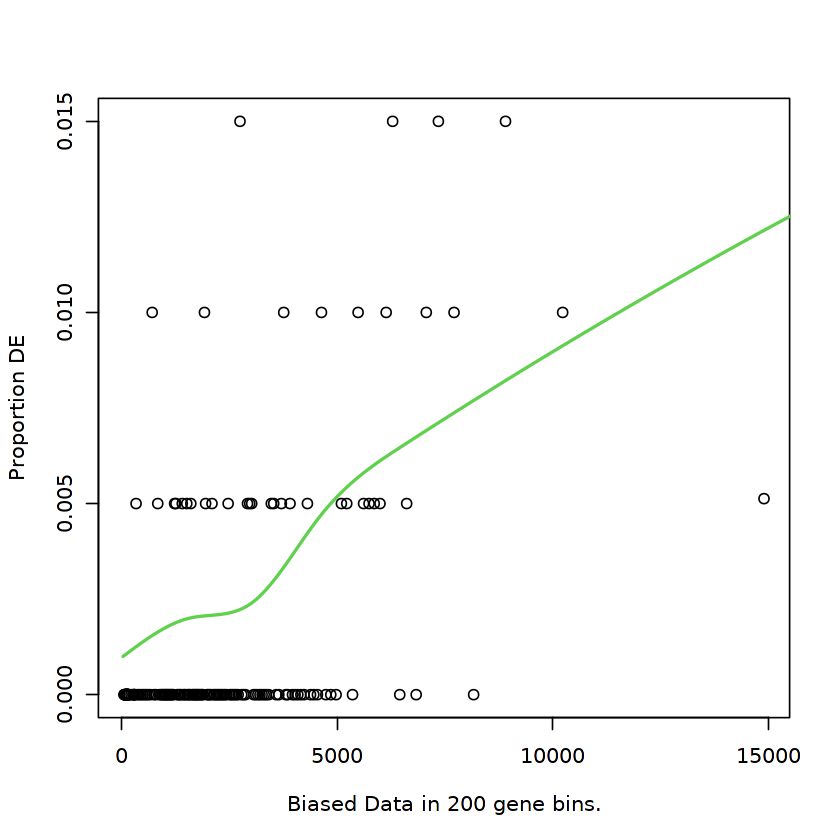

In [35]:
lymph_node_common.shared <- runMacaqueGO_custom(res_tmp, brain_node_common)

In [36]:
head(lymph_node_common.shared, n=10)

category   over_represented_pvalue under_represented_pvalue numDEInCat
3683  GO:0009607 0.000000e+00            1                        13        
3686  GO:0009615 0.000000e+00            1                        11        
8792  GO:0043207 0.000000e+00            1                        13        
9188  GO:0044419 0.000000e+00            1                        13        
10952 GO:0051607 0.000000e+00            1                        10        
10990 GO:0051707 0.000000e+00            1                        13        
13782 GO:0098542 0.000000e+00            1                        12        
748   GO:0002252 2.117332e-11            1                        10        
10527 GO:0050792 3.460062e-10            1                         7        
2859  GO:0006952 4.005646e-10            1                        12        
      numInCat term                                       ontology
3683  394      response to biotic stimulus                BP      
3686   95      response to virus                          BP      
8792  387      response to external biotic stimulus       BP      
9188  452      interspecies interaction between organisms BP      
10952  71      defense response to virus                  BP      
10990 385      response to other organism                 BP      
13782 274      defense response to other organism         BP      
748   189      immune effector process                    BP      
10527  64      regulation of viral process                BP      
2859  455      defense response                           BP

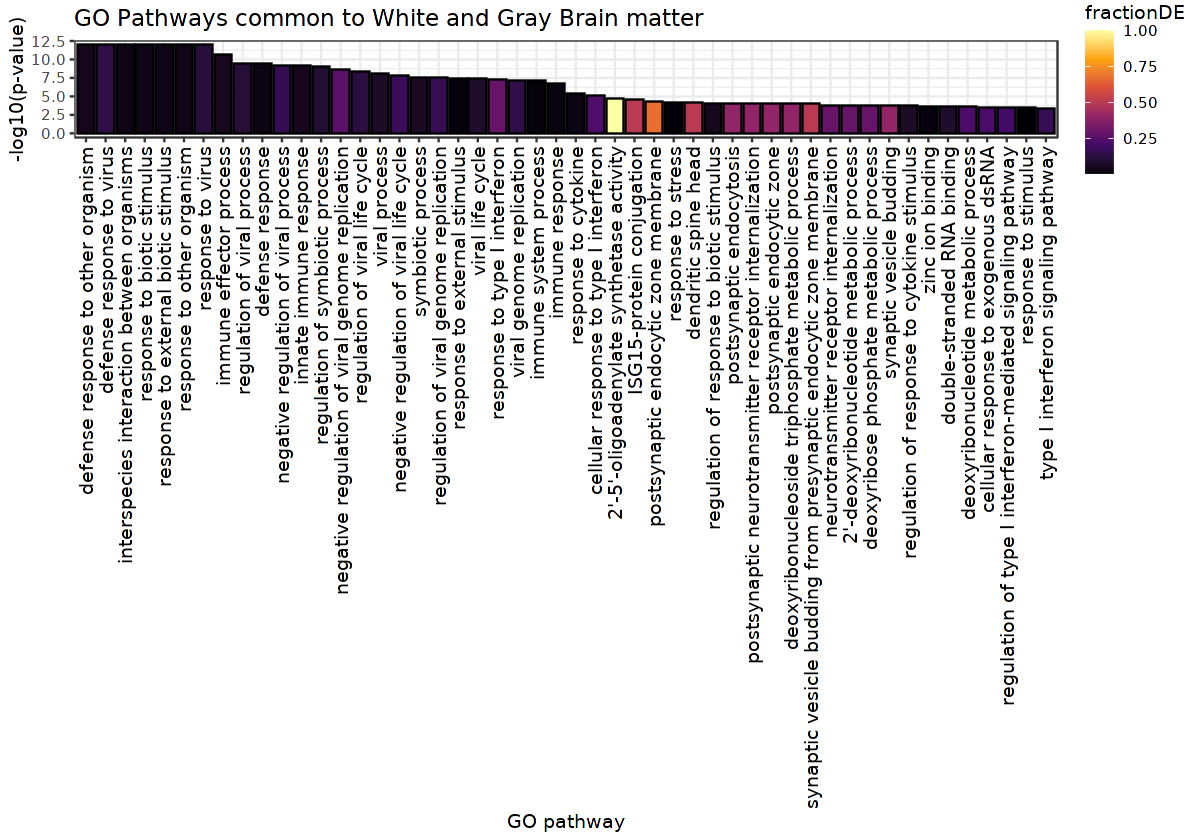

In [37]:
options(repr.plot.width = 10, repr.plot.height = 7)

lymph_node_common.shared %>% 
    mutate(fractionDE=numDEInCat/numInCat) %>%
    mutate(scaledPval= -log10(over_represented_pvalue+1e-12)) %>%
    head(n=50) %>% 
    ggplot(aes(x=reorder(term, desc(scaledPval)),fill=fractionDE,y=scaledPval)) + 
    geom_bar(stat='identity',color='black') +
    theme_bw() + 
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, color='black', size=11)) +
    scale_x_discrete(name="GO pathway") +
    scale_y_continuous(name="-log10(p-value)") + 
    scale_fill_viridis_c(option='B') +
    ggtitle("GO Pathways common to White and Gray Brain matter")

In [38]:
ggsave('output/go_pathways_common.png',w=10,h=7)

### Score samples for GO:0051607 defense response to virus

Response to Virus is up in both white and gray

In [39]:
score_brain_samples_go <- function(gopathway) {
    def.res.vir.genes.ens <- get_genes_in_go_cat_ens(gopathway)
    def.res.vir.genes.ens <- def.res.vir.genes.ens[def.res.vir.genes.ens %in% rowData(dds_simple)$Geneid_noversion]
    def.res.vir.genes.ens <- rownames(rowData(dds_simple))[match(def.res.vir.genes.ens, rowData(dds_simple)$Geneid_noversion)]
    scaled.expr <- scale(t(counts(dds_simple,normalized=TRUE)[def.res.vir.genes.ens,]),center=T,scale=T)
    sample.scores <- rowSums(scaled.expr[,colSums(is.na(scaled.expr)) == 0])
    sample.scores <- sample.scores[colnames(dds_simple)]
    plot.df <- as.data.frame(cbind(sample.scores, colData(dds_simple)))
    plot.df
}

'select()' returned 1:many mapping between keys and columns



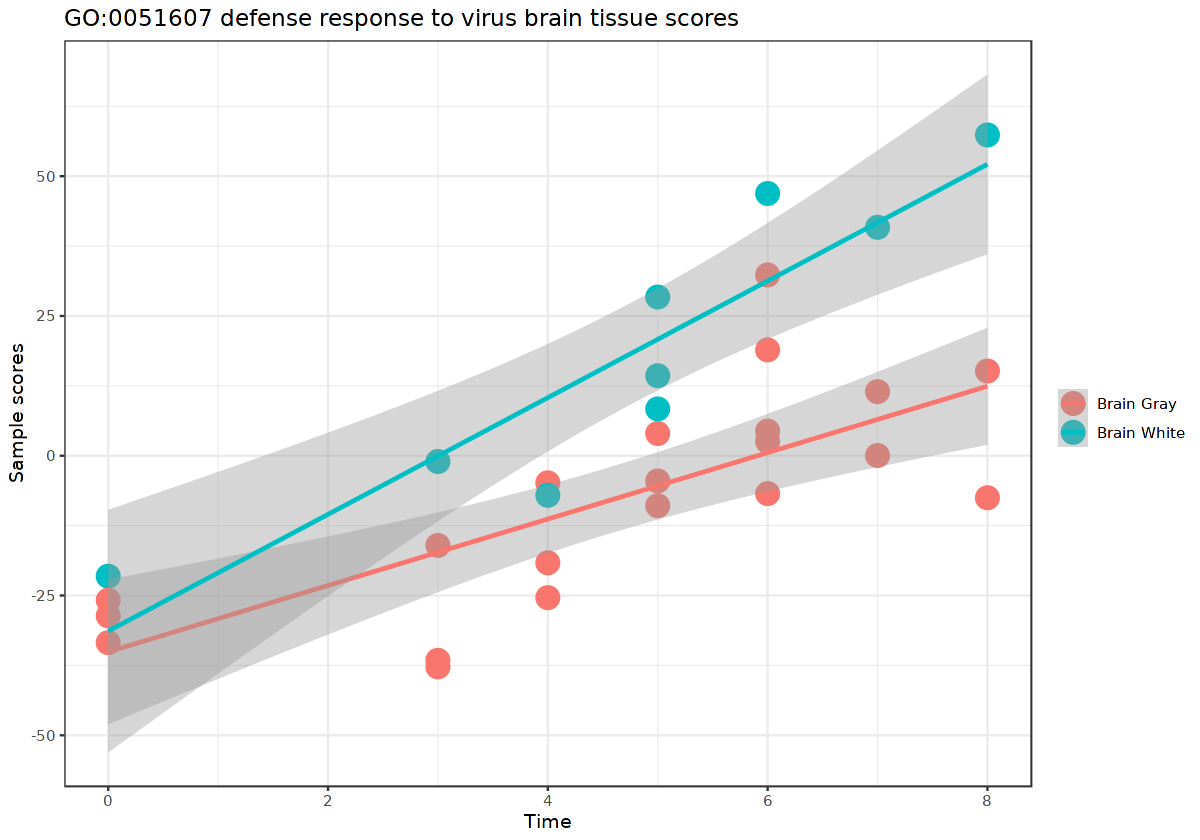

In [40]:
score_brain_samples_go("GO:0051607") %>% ggplot(aes(y=sample.scores,x=as.numeric(dpi_time_2), color=full.tissue)) + 
    geom_point(size=6) +
    theme_bw() + 
    geom_smooth(formula = y~x,method='lm') + 
    ggtitle("GO:0051607 defense response to virus brain tissue scores") +
    scale_y_continuous("Sample scores") +
    scale_x_continuous("Time") +
    scale_color_discrete(labels=c("Brain Gray","Brain White"),name=NULL)

In [41]:
ggsave("output/defence_virus_brain.png",w=10,h=10)

In [42]:
# GO:0006955 immune response

'select()' returned 1:many mapping between keys and columns



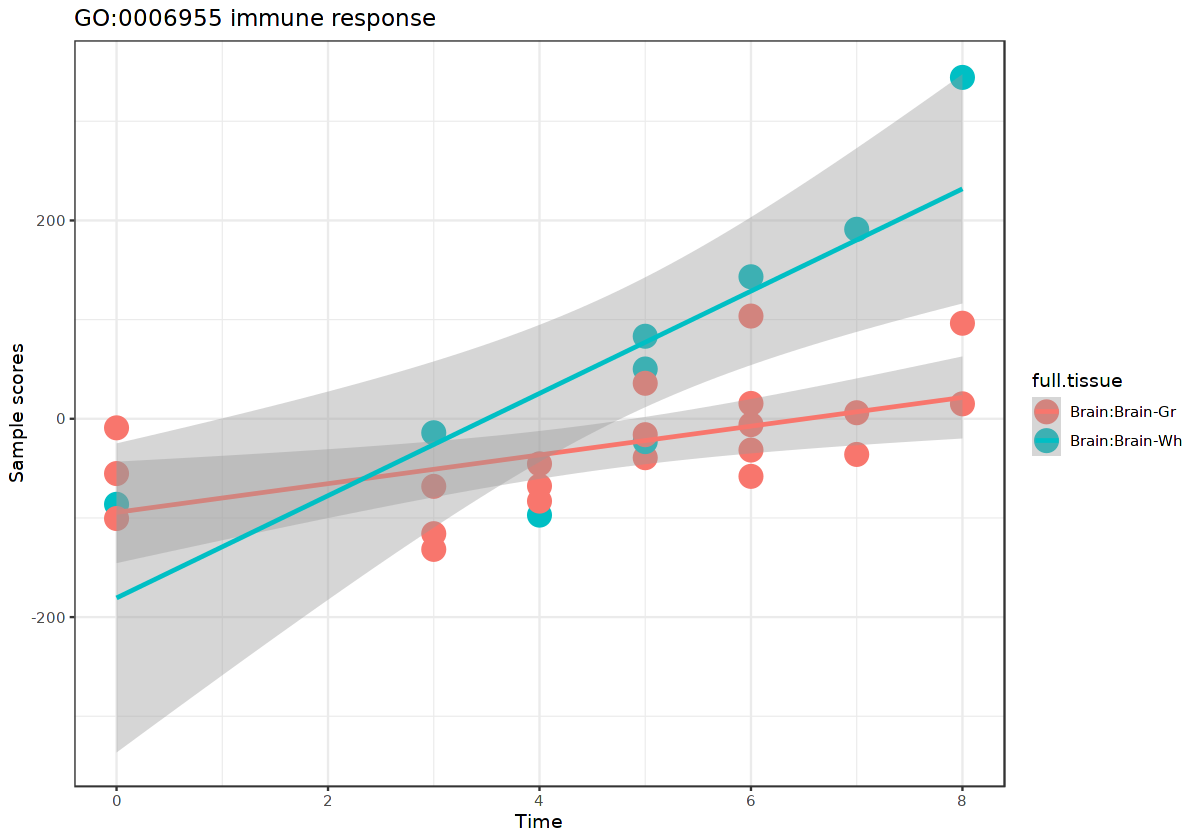

In [43]:
score_brain_samples_go("GO:0006955") %>% ggplot(aes(y=sample.scores,x=as.numeric(dpi_time_2), color=full.tissue)) + 
    geom_point(size=6) +
    theme_bw() + 
    geom_smooth(formula = y~x,method='lm') + 
    ggtitle("GO:0006955 immune response") +
    scale_y_continuous("Sample scores") +
    scale_x_continuous("Time")

In [44]:
ggsave("output/brain_immune_response_by_time.png",w=10,h=10)

## GO:0070231 T cell apoptotic process

'select()' returned 1:many mapping between keys and columns



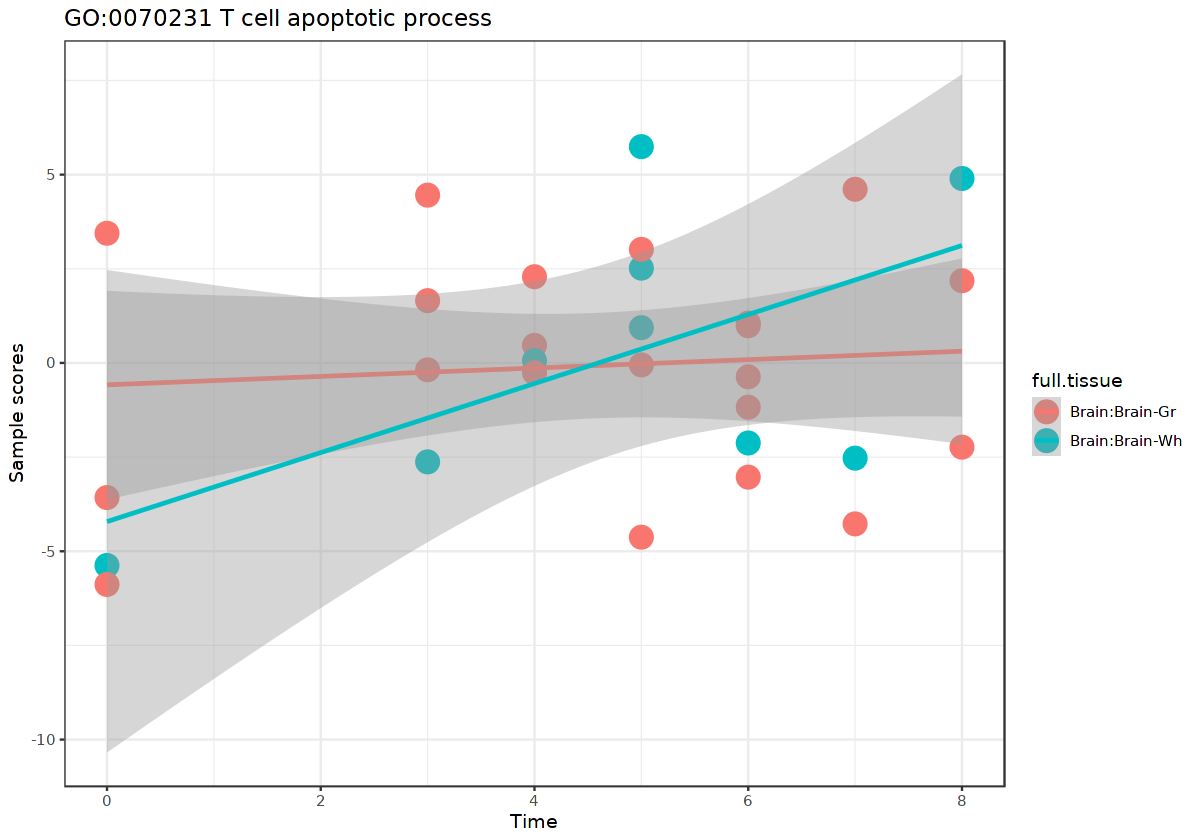

In [45]:
score_brain_samples_go("GO:0070231") %>% ggplot(aes(y=sample.scores,x=as.numeric(dpi_time_2), color=full.tissue)) + 
    geom_point(size=6) +
    theme_bw() + 
    geom_smooth(formula = y~x,method='lm') + 
    ggtitle("GO:0070231 T cell apoptotic process") +
    scale_y_continuous("Sample scores") +
    scale_x_continuous("Time")

'select()' returned 1:many mapping between keys and columns



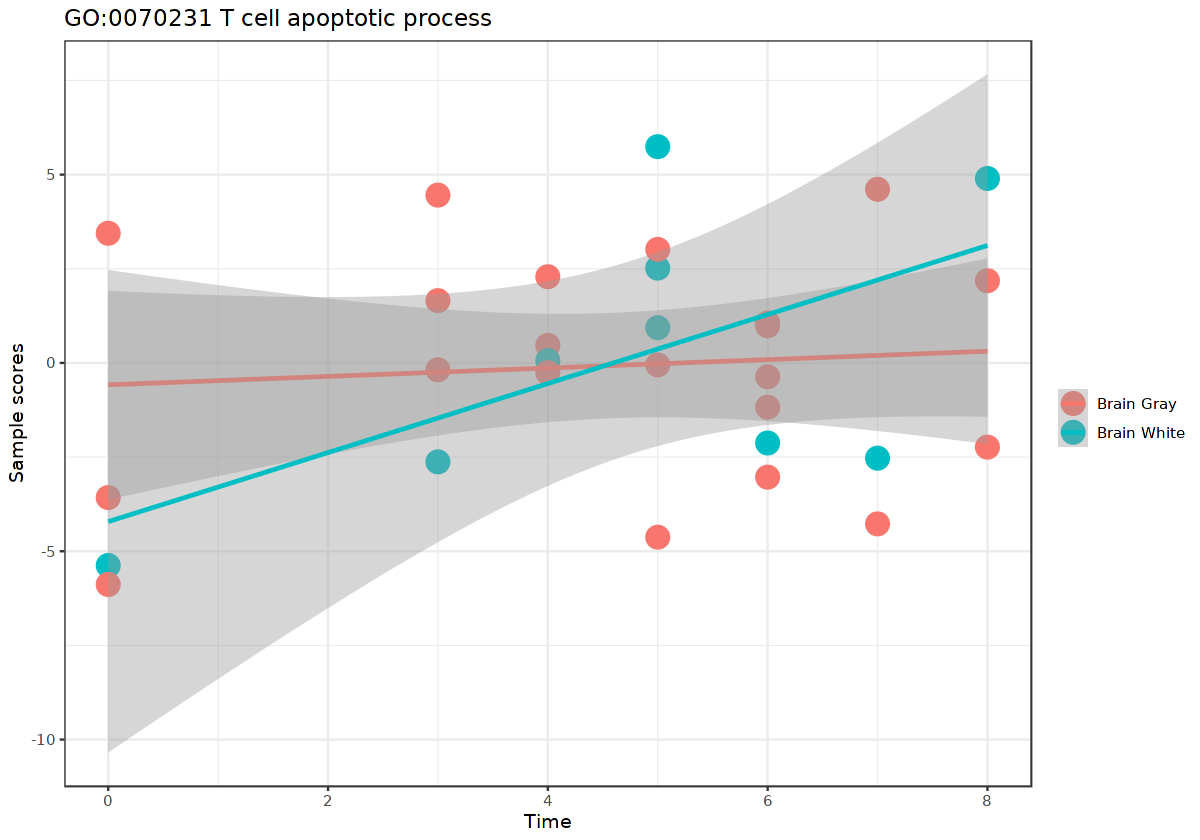

In [46]:
score_brain_samples_go("GO:0070231") %>% ggplot(aes(y=sample.scores,x=as.numeric(dpi_time_2), color=full.tissue)) + 
    geom_point(size=6) +
    theme_bw() + 
    geom_smooth(formula = y~x,method='lm') + 
    ggtitle("GO:0070231 T cell apoptotic process") +
    scale_y_continuous("Sample scores") +
    scale_x_continuous("Time") +
    scale_color_discrete(labels=c("Brain Gray","Brain White"),name=NULL)

'select()' returned 1:many mapping between keys and columns



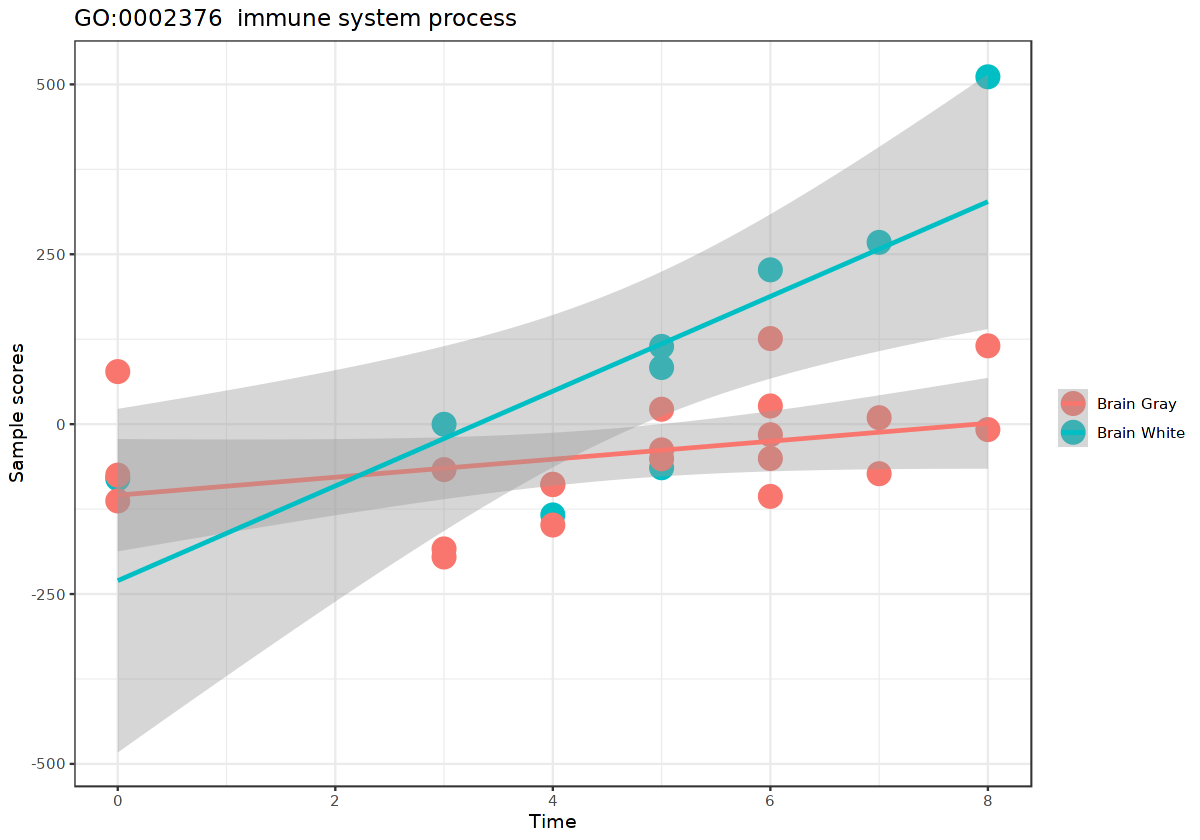

In [47]:
score_brain_samples_go("GO:0002376") %>% ggplot(aes(y=sample.scores,x=as.numeric(dpi_time_2), color=full.tissue)) + 
    geom_point(size=6) +
    theme_bw() + 
    geom_smooth(formula = y~x,method='lm') + 
    ggtitle("GO:0002376  immune system process") +
    scale_y_continuous("Sample scores") +
    scale_x_continuous("Time") +
    scale_color_discrete(labels=c("Brain Gray","Brain White"),name=NULL)

In [48]:
fastSave::preserve.state()

[1] "savepoint_2021-06-28_19:43:01_31968.RDataFS"